# Adding activity chains to synthetic populations 

The purpose of this script is to match each individual in the synthetic population to a respondant from the [National Travel Survey (NTS)](https://beta.ukdataservice.ac.uk/datacatalogue/studies/study?id=5340). 

### Methods

We will try two methods

1. categorical matching: joining on relevant socio-demographic variables
2. statistical matching, as described in [An unconstrained statistical matching algorithm for combining individual and household level geo-specific census and survey data](https://doi.org/10.1016/j.compenvurbsys.2016.11.003). 

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import geopandas as gpd
from sklearn.neighbors import NearestNeighbors
import pickle as pkl

from acbm.matching import match_individuals, match_psm
from acbm.preprocessing import (
    count_per_group,
    nts_filter_by_region,
    nts_filter_by_year,
    num_adult_child_hh,
    transform_by_group,
    truncate_values,
    match_coverage_col
)

pd.set_option('display.max_columns', None)

## Step 1: Load in the datasets  

### SPC 

In [2]:
# useful variables
region = "west-yorkshire"

In [3]:
# Read in the spc data (parquet format)
spc = pd.read_parquet('../data/external/spc_output/' + region + '_people_hh.parquet')
spc.head()

id  household  workplace  \
0   0          0        NaN   
1   1          1        NaN   
2   2          1        NaN   
3   3          2    56126.0   
4   4          2        NaN   

                                            location  \
0  {'x': -1.7892179489135742, 'y': 53.91915130615...   
1  {'x': -1.8262380361557007, 'y': 53.92028045654...   
2  {'x': -1.8262380361557007, 'y': 53.92028045654...   
3  {'x': -1.8749940395355225, 'y': 53.94298934936...   
4  {'x': -1.8749940395355225, 'y': 53.94298934936...   

                                              events  \
0  {'concert_f': 1.2791347489984115e-31, 'concert...   
1  {'concert_f': 9.743248151956307e-21, 'concert_...   
2  {'concert_f': 8.46716103992468e-16, 'concert_f...   
3  {'concert_f': 1.8844366073608398, 'concert_fs'...   
4  {'concert_f': 4.877435207366943, 'concert_fs':...   

                                     weekday_diaries  \
0                                      [1583, 13161]   
1  [2900, 4948, 4972, 7424, 10284, 10586, 12199, ...   
2                   [3010, 6389, 9448, 10184, 11598]   
3  [366, 867, 2096, 3678, 5212, 5450, 8145, 9254,...   
4                               [1289, 12528, 12870]   

                                     weekend_diaries            orig_pid  \
0                                      [1582, 13160]  E02002183_0001_001   
1  [2901, 4949, 4973, 7425, 10285, 10585, 12198, ...  E02002183_0002_001   
2                   [3011, 6388, 9447, 10183, 11599]  E02002183_0002_002   
3  [365, 868, 2097, 3677, 5213, 5451, 8146, 9253,...  E02002183_0003_001   
4                               [1288, 12529, 12871]  E02002183_0003_002   

   id_tus_hh  id_tus_p   pid_hs       msoa         oa members        bmi  \
0   11291218         1  2905399  E02002183  E00053954     [0]  24.879356   
1   17291219         1  2905308  E02002183  E00053953  [1, 2]  27.491207   
2   17070713         2  2907681  E02002183  E00053953  [1, 2]  17.310829   
3   20310313         1  2902817  E02002183  E00053689  [3, 4]  20.852091   
4   13010909         3  2900884  E02002183  E00053689  [3, 4]  20.032526   

   has_cardiovascular_disease  has_diabetes  has_high_blood_pressure  \
0                       False         False                    False   
1                       False         False                     True   
2                       False          True                     True   
3                       False         False                    False   
4                       False         False                    False   

   number_medications  self_assessed_health  life_satisfaction sic1d2007  \
0                 NaN                   3.0                2.0         J   
1                 NaN                   3.0                NaN         C   
2                 NaN                   2.0                4.0         P   
3                 NaN                   2.0                1.0         C   
4                 1.0                   2.0                3.0         J   

   sic2d2007  soc2010  pwkstat  salary_yearly  salary_hourly             hid  \
0       58.0   1115.0        6            NaN            NaN  E02002183_0001   
1       25.0   1121.0        6            NaN            NaN  E02002183_0002   
2       85.0   2311.0        6            NaN            NaN  E02002183_0002   
3       31.0   3422.0        1   32857.859375      14.360952  E02002183_0003   
4       62.0   7214.0        1   18162.451172       9.439944  E02002183_0003   

   accommodation_type  communal_type  num_rooms  central_heat  tenure  \
0                 1.0            NaN        2.0          True     2.0   
1                 3.0            NaN        6.0          True     2.0   
2                 3.0            NaN        6.0          True     2.0   
3                 3.0            NaN        6.0          True     2.0   
4                 3.0            NaN        6.0          True     2.0   

   num_cars  sex  age_years  ethnicity  nssec8  
0         2    1         86     

In [4]:
# select columns
spc = spc[['id', 'household', 'location', 'pid_hs',
       'msoa', 'oa', 'members', 'sic1d2007', 'sic2d2007',
       'pwkstat', 'salary_yearly', 'salary_hourly', 'hid',
       'accommodation_type', 'communal_type', 'num_rooms', 'central_heat',
       'tenure', 'num_cars', 'sex', 'age_years', 'ethnicity', 'nssec8']]

In [5]:
# temporary reduction of the dataset for quick analysis
spc = spc.head(15000)

### NTS

The NTS is split up into multiple tables. We will load in the following tables:
- individuals
- households
- trips

In [6]:
path_psu = "../data/external/nts/UKDA-5340-tab/tab/psu_eul_2002-2022.tab"
psu = pd.read_csv(path_psu, sep="\t")

#### Individuals

In [7]:
path_individuals = "../data/external/nts/UKDA-5340-tab/tab/individual_eul_2002-2022.tab"
nts_individuals = pd.read_csv(path_individuals,
                              sep="\t",
                              usecols = ['IndividualID',
                                         'HouseholdID',
                                          'PSUID',
                                          'Age_B01ID',
                                          'Age_B04ID',
                                          'Sex_B01ID',
                                          'OfPenAge_B01ID',
                                          'HRPRelation_B01ID',
                                          'EdAttn1_B01ID',
                                          'EdAttn2_B01ID',
                                          'EdAttn3_B01ID',
                                          'OwnCycle_B01ID', # Owns a cycle
                                          'DrivLic_B02ID', # type of driving license
                                          'CarAccess_B01ID',
                                          'IndIncome2002_B02ID',
                                          'IndWkGOR_B02ID', # Region of usual place of work
                                          'EcoStat_B02ID', # Working status of individual
                                          'EcoStat_B03ID',
                                          'NSSec_B03ID', # NSSEC high level breakdown
                                          'SC_B01ID', # Social class of individual
                                          'Stat_B01ID', # employee or self-employed
                                          'WkMode_B01ID', # Usual means of travel to work
                                          'WkHome_B01ID', # Work from home
                                          'PossHom_B01ID', # Is it possible to work from home?
                                          'OftHome_B01ID', # How often work from home
                                          'TravSh_B01ID', # Usual mode from main food shopping trip
                                          'SchDly_B01ID', # Daily school journey?
                                          'SchTrav_B01ID', # Usual mode of travel to school
                                          'SchAcc_B01ID', # IS school trip accompanied by an adult?
                                          'FdShp_B01ID', # How do you usually carry ot main food shop (go to shop, online etc)
                                          ]
)




#### Households

In [8]:
path_households = "../data/external/nts/UKDA-5340-tab/tab/household_eul_2002-2022.tab"
nts_households = pd.read_csv(path_households,
                             sep="\t",
                             usecols = ['HouseholdID',
                                        'PSUID',
                                        'HHIncome2002_B02ID',
                                        'AddressType_B01ID', # type of house
                                        'Ten1_B02ID', # type of tenure
                                        'HHoldNumAdults', # total no. of adults in household
                                        'HHoldNumChildren', # total no. of children in household
                                        'HHoldNumPeople', # total no. of people in household
                                        'NumLicHolders', # total no. of driving license holders in household
                                        'HHoldEmploy_B01ID', # number of employed in household
                                        'NumBike', # no. of bikes
                                        'NumCar', # no. of cars
                                        'NumVanLorry', # no. of vans or lorries
                                        'NumMCycle', # no. of motorcycles
                                        'WalkBus_B01ID', # walk time from house to nearest bus stop
                                        'Getbus_B01ID', # frequency of bus service
                                        'WalkRail_B01ID', # walk time from house to nearest rail station
                                        'JTimeHosp_B01ID', # journey time to nearest hospital
                                        'DVShop_B01ID', # person no. for main food shooper in hh
                                        'Settlement2011EW_B03ID', # ONS Urban/Rural: 2 categories
                                        'Settlement2011EW_B04ID', # ONS Urban/Rural: 3 categories
                                        'HHoldOAClass2011_B03ID', # Census 2011 OA Classification
                                        'HRPWorkStat_B02ID', # HH ref person working status
                                        'HRPSEGWorkStat_B01ID', #  HH ref person socio economic group for active workers
                                        'W0', # Unweighted interview sample
                                        'W1', # Unweighted diary sample
                                        'W2', # Weighted diary sample
                                        'W3', # Weighted interview sample
                                        ]
  )

#### Trips

In [9]:

path_trips = "../data/external/nts/UKDA-5340-tab/tab/trip_eul_2002-2022.tab"
nts_trips = pd.read_csv(path_trips,
                        sep="\t",
                        usecols = ['TripID',
                                   'DayID',
                                   'IndividualID',
                                   'HouseholdID',
                                   'PSUID',
                                   'PersNo',
                                   'TravDay',
                                   'JourSeq',
                                   'ShortWalkTrip_B01ID',
                                   'NumStages',
                                   'MainMode_B03ID',
                                   'MainMode_B04ID',
                                   'TripPurpFrom_B01ID',
                                   'TripPurpTo_B01ID',
                                   'TripPurpose_B04ID',
                                   'TripStart',
                                   'TripEnd',
                                   'TripTotalTime',
                                   'TripTravTime',
                                   'TripDisIncSW',
                                   'TripDisExSW',
                                   'TripOrigGOR_B02ID',
                                   'TripDestGOR_B02ID',
                                   'W5',
                                   'W5xHH'
                        ]
    )


#### Filter by year

We will filter the NTS data to only include data from specific years. We can choose only 1 year, or multiple years to increase our sample size and the likelihood of a match with the spc

In [10]:
years = [2019, 2021, 2022]

nts_individuals_filtered = nts_filter_by_year(nts_individuals, psu, years)
nts_households_filtered = nts_filter_by_year(nts_households, psu, years)
nts_trips_filtered = nts_filter_by_year(nts_trips, psu, years)



#### Filter by geography 

I will not do this for categorical matching, as it reduces the sample significantly, and leads to more spc households not being matched

In [11]:
# regions = ['Yorkshire and the Humber', 'North West']

# nts_individuals_filtered = nts_filter_by_region(nts_individuals_filtered, psu, regions)
# nts_households_filtered = nts_filter_by_region(nts_households_filtered, psu, regions)
# nts_trips_filtered = nts_filter_by_region(nts_trips_filtered, psu, regions)


Create dictionaries of key value pairs

In [12]:
'''
guide to the dictionaries:

_nts_hh: from NTS households table
_nts_ind: from NTS individuals table
_spc: from SPC

'''


# ---------- NTS

# Create a dictionary for the HHIncome2002_B02ID column
income_dict_nts_hh = {
     '1': '0-25k',
     '2': '25k-50k',
     '3': '50k+',
    '-8': 'NA',
    # should be -10, but
    # it could be a typo in household_eul_2002-2022_ukda_data_dictionary
    '-1': 'DEAD'
}

# Create a dictionary for the HHoldEmploy_B01ID column
# (PT: Part time, FT: Full time)
employment_dict_nts_hh = {
    '1': 'None',
    '2': '0 FT, 1 PT',
    '3': '1 FT, 0 PT',
    '4': '0 FT, 2 PT',
    '5': '1 FT, 1 PT',
    '6': '2 FT, 0 PT',
    '7': '1 FT, 2+ PT',
    '8': '2 FT, 1+ PT',
    '9': '0 FT, 3+ PT',
    '10': '3+ FT, 0 PT',
    '11': '3+ FT, 1+ PT',
    '-8': 'NA',
    '-10': 'DEAD'
}

# Create a dictionary for the Ten1_B02ID column
tenure_dict_nts_hh = {
    '1': 'Owns / buying',
    '2': 'Rents',
    '3': 'Other (including rent free)',
    '-8': 'NA',
    '-9': 'DNA',
    '-10': 'DEAD'
}


# ---------- SPC


# create a dictionary for the pwkstat column
employment_dict_spc = {
    '0': 'Not applicable (age < 16)',
    '1': 'Employee FT',
    '2': 'Employee PT',
    '3': 'Employee unspecified',
    '4': 'Self-employed',
    '5': 'Unemployed',
    '6': 'Retired',
    '7': 'Homemaker/Maternal leave',
    '8': 'Student',
    '9': 'Long term sickness/disability',
    '10': 'Other'
}


# Create a dictionary for the tenure column
tenure_dict_spc = {
    '1': 'Owned: Owned outright',
    '2': 'Owned: Owned with a mortgage or loan or shared ownership',
    '3': 'Rented or living rent free: Total',
    '4': 'Rented: Social rented',
    '5': 'Rented: Private rented or living rent free',
    '-8': 'NA',
    '-9': 'DNA',
    '-10': 'DEAD'
}


# Combine the dictionaries into a dictionary of dictionaries

dict_nts = {
    'HHIncome2002_B02ID': income_dict_nts_hh,
    'HHoldEmploy_B01ID': employment_dict_nts_hh,
    'Ten1_B02ID': tenure_dict_nts_hh
}

dict_spc = {
    'pwkstat': employment_dict_spc,
    'tenure': tenure_dict_spc
}



## Step 2: Decide on matching variables  

We need to identify the socio-demographic characteristics that we will match on. The schema for the synthetic population can be found [here](https://github.com/alan-turing-institute/uatk-spc/blob/main/synthpop.proto). 

Matching between the SPC and the NTS will happen in two steps: 

1. Match at the household level
2. Match individuals within the household

### Household level matching 

| Variable           | Name (NTS)           | Name (SPC)      | Transformation (NTS) | Transformation (SPC) |
| ------------------ | -------------------- | --------------- | -------------------- | -------------------- |
| Household income   | `HHIncome2002_BO2ID` | `salary_yearly` | NA                   | Group by household ID and sum |
| Number of adults   | `HHoldNumAdults`        | `age_years`     | NA                   | Group by household ID and count |
| Number of children | `HHoldNumChildren`      | `age_years`     | NA                   | Group by household ID and count |
| Employment status  | `HHoldEmploy_B01ID`  | `pwkstat`       | NA                   | a) match to NTS categories. b) group by household ID |
| Car ownership      | `NumCar`             | `num_cars`      | SPC is capped at 2. We change all entries > 2 to 2 | NA  |

Other columns to match in the future
| Variable           | Name (NTS)           | Name (SPC)      | Transformation (NTS) | Transformation (SPC) |
| ------------------ | -------------------- | --------------- | -------------------- | -------------------- |
| Type of tenancy    | `Ten1_B02ID`         | `tenure`        | ?? | ?? |
|  Urban-Rural classification of residence | `Settlement2011EW_B04ID`         | NA     | NA            | Spatial join between [layer](https://www.gov.uk/government/collections/rural-urban-classification) and SPC  |



### 2.1 Edit SPC columns 

#### Household Income

Edit the spc so that we have household income as well as individual income.

In [13]:
# add household income column for SPC
spc_edited = transform_by_group(data = spc,
                                group_col = 'household',
                                transform_col = 'salary_yearly',
                                new_col = 'salary_yearly_hh',
                                transformation_type = 'sum')


Check number of individuals and households with reported salaries

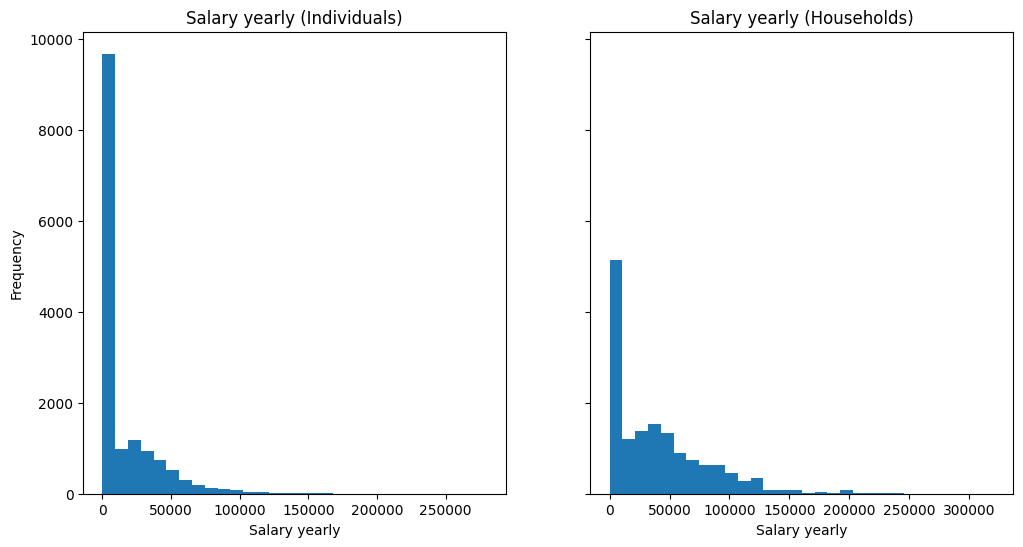

Individuals in SPC = 15000
Individuals without reported income = 9226
% of individuals with reported income = 38.5
Individuals with reported income: 0 = 0
Households in SPC = 6725
Households without reported income = 4605
% of households with reported income = 68.5
Households with reported income: 0 = 4605


In [14]:
# histogram for individuals and households (include NAs as 0)
fig, ax = plt.subplots(1, 2, figsize=(12, 6), sharey=True)
ax[0].hist(spc_edited['salary_yearly'].fillna(0), bins=30)
ax[0].set_title('Salary yearly (Individuals)')
ax[0].set_xlabel('Salary yearly')
ax[0].set_ylabel('Frequency')
ax[1].hist(spc_edited['salary_yearly_hh'].fillna(0), bins=30)
ax[1].set_title('Salary yearly (Households)')
ax[1].set_xlabel('Salary yearly')
plt.show()


# statistics

# print the total number of rows in the spc. Add a message "Values ="
print("Individuals in SPC =", spc_edited.shape[0])
# number of individuals without reported income
print("Individuals without reported income =", spc_edited['salary_yearly'].isna().sum())
# % of individuals with reported income (salary_yearly not equal NA)
print("% of individuals with reported income =", round((spc_edited['salary_yearly'].count() / spc_edited.shape[0]) * 100, 1))
print("Individuals with reported income: 0 =", spc_edited[spc_edited['salary_yearly'] == 0].shape[0])


# print the total number of households
print("Households in SPC =", spc_edited['household'].nunique())
# number of households without reported income (salary yearly_hh = 0)
print("Households without reported income =", spc_edited[spc_edited['salary_yearly_hh'] == 0].shape[0])
# # % of households with reported income (salary_yearly not equal NA)
print("% of households with reported income =", round((spc_edited[spc_edited['salary_yearly_hh'] == 0].shape[0] / spc_edited['household'].nunique()) * 100, 1))
print("Households with reported income: 0 =", spc_edited[spc_edited['salary_yearly_hh'] == 0].shape[0])


In [15]:
# --- Recode column so that it matches the reported NTS values (Use income_dict_nts_hh dictionary for reference)

# Define the bins (first )
bins = [0, 24999, 49999, np.inf]
# Define the labels for the bins
labels = [1, 2, 3]

spc_edited = spc_edited.copy()

spc_edited['salary_yearly_hh_cat'] = (pd.cut(spc_edited['salary_yearly_hh'], bins=bins, labels=labels, include_lowest=True)
                                       .astype('str')
                                       .astype('float'))


# replace NA values with -8 (to be consistent with NTS)
spc_edited['salary_yearly_hh_cat'] = spc_edited['salary_yearly_hh_cat'].fillna(-8)

# Convert the column to int
spc_edited['salary_yearly_hh_cat'] = spc_edited['salary_yearly_hh_cat'].astype('int')

If we compare household income from the SPC and the NTS, we find that the SPC has many more households with no reported income (-8). This will create an issue when matching using household income

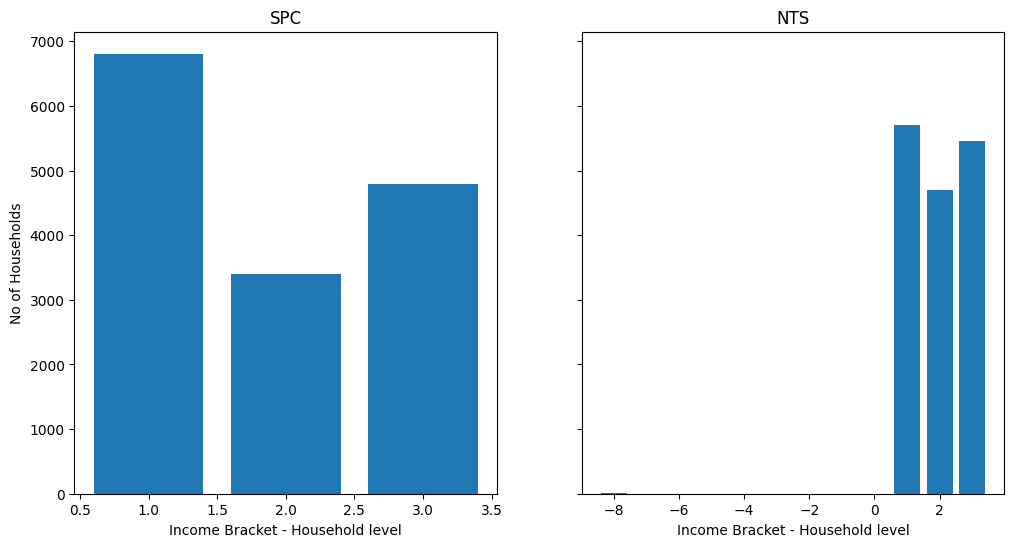

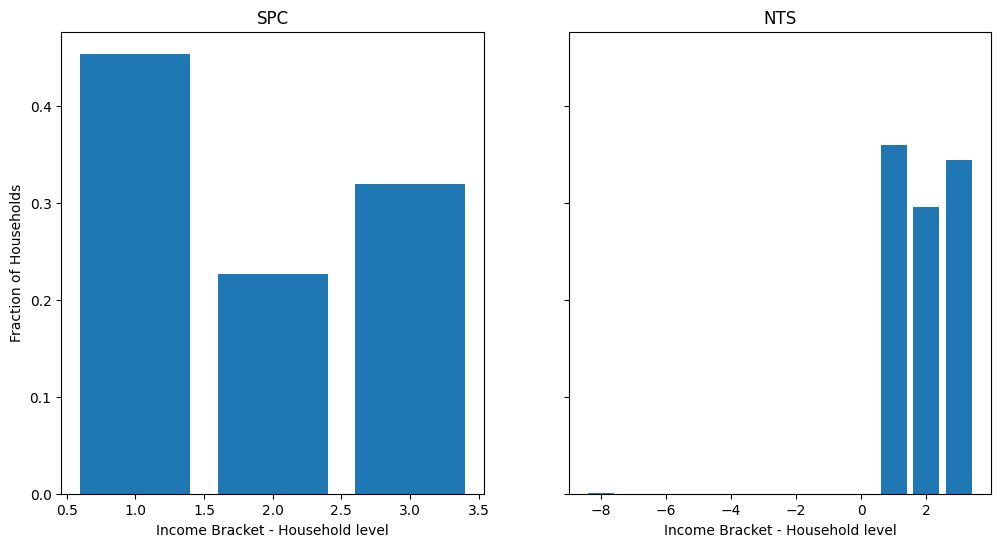

In [16]:
# bar plot showing spc_edited.salary_yearly_hh_cat and nts_households_filtered.HHIncome2002_B02ID side by side
fig, ax = plt.subplots(1, 2, figsize=(12, 6), sharey=True)
ax[0].bar(spc_edited['salary_yearly_hh_cat'].value_counts().index, spc_edited['salary_yearly_hh_cat'].value_counts().values)
ax[0].set_title('SPC')
ax[0].set_xlabel('Income Bracket - Household level')
ax[0].set_ylabel('No of Households')
ax[1].bar(nts_households_filtered['HHIncome2002_B02ID'].value_counts().index, nts_households_filtered['HHIncome2002_B02ID'].value_counts().values)
ax[1].set_title('NTS')
ax[1].set_xlabel('Income Bracket - Household level')
plt.show()

# same as above but (%)
fig, ax = plt.subplots(1, 2, figsize=(12, 6), sharey=True)
ax[0].bar(spc_edited['salary_yearly_hh_cat'].value_counts(normalize=True).index, spc_edited['salary_yearly_hh_cat'].value_counts(normalize=True).values)
ax[0].set_title('SPC')
ax[0].set_xlabel('Income Bracket - Household level')
ax[0].set_ylabel('Fraction of Households')
ax[1].bar(nts_households_filtered['HHIncome2002_B02ID'].value_counts(normalize=True).index, nts_households_filtered['HHIncome2002_B02ID'].value_counts(normalize=True).values)
ax[1].set_title('NTS')
ax[1].set_xlabel('Income Bracket - Household level')
plt.show()

In [17]:
# get the % of households in each income bracket for the nts
nts_households_filtered['HHIncome2002_B02ID'].value_counts(normalize=True) * 100

HHIncome2002_B02ID
 1.0    35.969773
 3.0    34.382872
 2.0    29.559194
-8.0     0.088161
Name: proportion, dtype: float64

#### Household Composition (No. of Adults / Children)

In [18]:
# Number of adults and children in the household

spc_edited = num_adult_child_hh(data = spc_edited,
                                group_col = 'household',
                                age_col = 'age_years')

#### Employment Status

In [19]:
# Employment status

# check the colums values from our dictionary
dict_spc['pwkstat'], dict_nts['HHoldEmploy_B01ID']

({'0': 'Not applicable (age < 16)',
  '1': 'Employee FT',
  '2': 'Employee PT',
  '3': 'Employee unspecified',
  '4': 'Self-employed',
  '5': 'Unemployed',
  '6': 'Retired',
  '7': 'Homemaker/Maternal leave',
  '8': 'Student',
  '9': 'Long term sickness/disability',
  '10': 'Other'},
 {'1': 'None',
  '2': '0 FT, 1 PT',
  '3': '1 FT, 0 PT',
  '4': '0 FT, 2 PT',
  '5': '1 FT, 1 PT',
  '6': '2 FT, 0 PT',
  '7': '1 FT, 2+ PT',
  '8': '2 FT, 1+ PT',
  '9': '0 FT, 3+ PT',
  '10': '3+ FT, 0 PT',
  '11': '3+ FT, 1+ PT',
  '-8': 'NA',
  '-10': 'DEAD'})

The NTS only reports the number of Full time and Part time employees for each household. For the SPC we also need to get the number of full time and part time workers for each household.

Step 1: Create a column for Full time and a column for Part time

In [20]:
# We will only use '1' and '2' for the employment status

counts_df = count_per_group(df = spc_edited,
                            group_col = 'household',
                            count_col = 'pwkstat',
                            values=[1, 2],
                            value_names=['pwkstat_FT_hh','pwkstat_PT_hh'])

counts_df.head(10)

pwkstat_FT_hh  pwkstat_PT_hh
household                              
0                      0              0
1                      0              0
2                      2              0
3                      1              0
4                      0              0
5                      1              0
6                      0              0
7                      1              0
8                      1              0
9                      0              1

Create a column that matches the NTS categories (m FT, n PT)

In [21]:
# We want to match the SPC values to the NTS
dict_nts['HHoldEmploy_B01ID']
'''
{
    '1': 'None',
    '2': '0 FT, 1 PT',
    '3': '1 FT, 0 PT',
    '4': '0 FT, 2 PT',
    '5': '1 FT, 1 PT',
    '6': '2 FT, 0 PT',
    '7': '1 FT, 2+ PT',
    '8': '2 FT, 1+ PT',
    '9': '0 FT, 3+ PT',
    '10': '3+ FT, 0 PT',
    '11': '3+ FT, 1+ PT',
    '-8': 'NA',
    '-10': 'DEAD'}
 '''

# 1) Match each row to the NTS

# Define the conditions and outputs.
# We are using the keys in dict_nts['HHoldEmploy_B01ID'] as reference
conditions = [
    (counts_df['pwkstat_FT_hh'] == 0) & (counts_df['pwkstat_PT_hh'] == 0),
    (counts_df['pwkstat_FT_hh'] == 0) & (counts_df['pwkstat_PT_hh'] == 1),
    (counts_df['pwkstat_FT_hh'] == 1) & (counts_df['pwkstat_PT_hh'] == 0),
    (counts_df['pwkstat_FT_hh'] == 0) & (counts_df['pwkstat_PT_hh'] == 2),
    (counts_df['pwkstat_FT_hh'] == 1) & (counts_df['pwkstat_PT_hh'] == 1),
    (counts_df['pwkstat_FT_hh'] == 2) & (counts_df['pwkstat_PT_hh'] == 0),
    (counts_df['pwkstat_FT_hh'] == 1) & (counts_df['pwkstat_PT_hh'] >= 2),
    (counts_df['pwkstat_FT_hh'] == 2) & (counts_df['pwkstat_PT_hh'] >= 1),
    (counts_df['pwkstat_FT_hh'] == 0) & (counts_df['pwkstat_PT_hh'] >= 3),
    (counts_df['pwkstat_FT_hh'] >= 3) & (counts_df['pwkstat_PT_hh'] == 0),
    (counts_df['pwkstat_FT_hh'] >= 3) & (counts_df['pwkstat_PT_hh'] >= 1)
]

# Define the corresponding outputs based on dict_nts['HHoldEmploy_B01ID]
outputs = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]

# Create a new column using np.select
counts_df['pwkstat_NTS_match'] = np.select(conditions,
                                           outputs,
                                           default= -8)



# 2) merge back onto the spc
spc_edited = spc_edited.merge(counts_df, left_on='household', right_index=True)

# check the output
spc_edited[['household', 'pwkstat', 'pwkstat_FT_hh', 'pwkstat_PT_hh', 'pwkstat_NTS_match']].head(10)


household  pwkstat  pwkstat_FT_hh  pwkstat_PT_hh  pwkstat_NTS_match
0          0        6              0              0                  1
1          1        6              0              0                  1
2          1        6              0              0                  1
3          2        1              2              0                  6
4          2        1              2              0                  6
5          3        1              1              0                  3
6          4       10              0              0                  1
7          4        4              0              0                  1
8          4        0              0              0                  1
9          5        1              1              0                  3

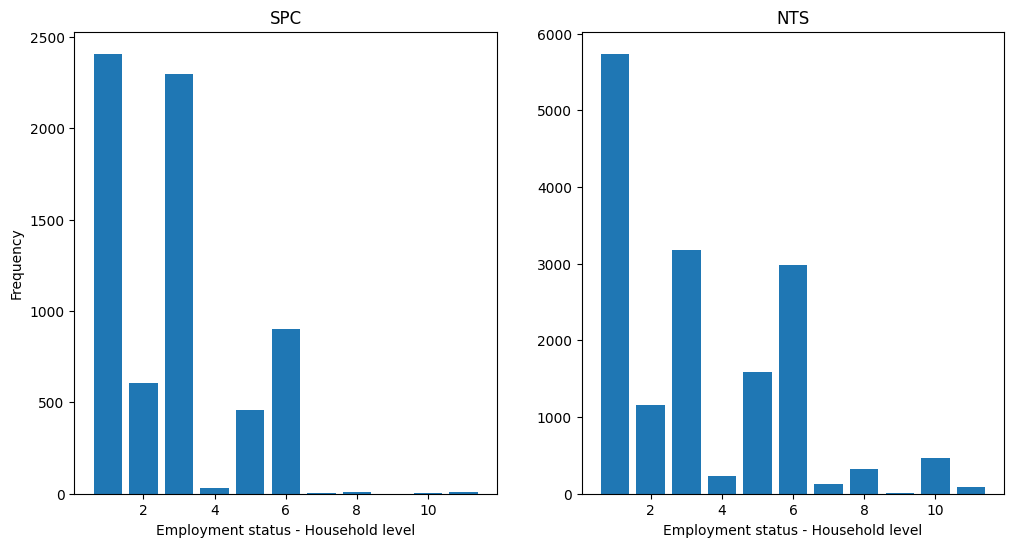

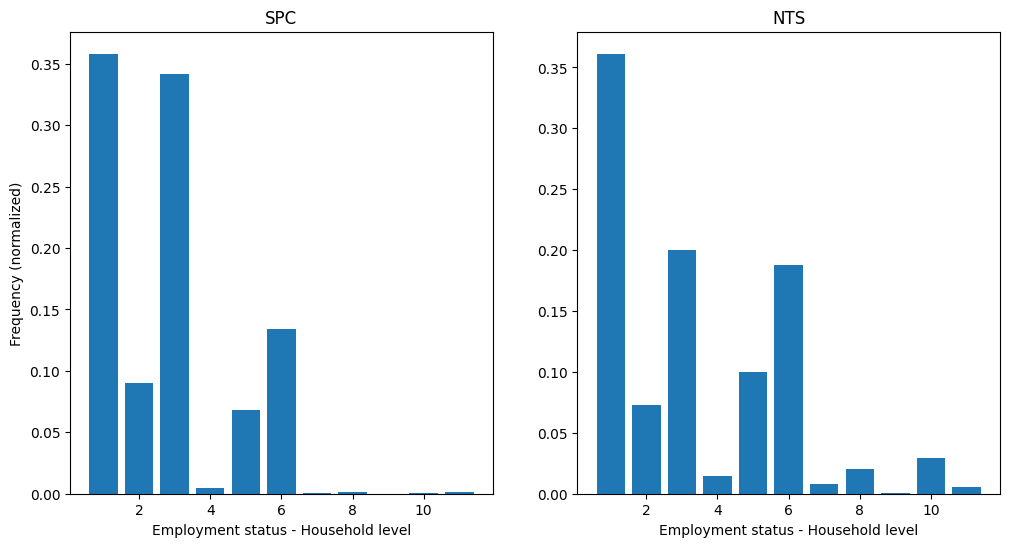

In [22]:
# bar plot of counts_df['pwkstat_NTS_match'] and nts_households_filtered['HHoldEmploy_B01ID']
fig, ax = plt.subplots(1, 2, figsize=(12, 6))
ax[0].bar(counts_df['pwkstat_NTS_match'].value_counts().index, counts_df['pwkstat_NTS_match'].value_counts().values)
ax[0].set_title('SPC')
ax[0].set_xlabel('Employment status - Household level')
ax[0].set_ylabel('Frequency')
ax[1].bar(nts_households_filtered['HHoldEmploy_B01ID'].value_counts().index, nts_households_filtered['HHoldEmploy_B01ID'].value_counts().values)
ax[1].set_title('NTS')
ax[1].set_xlabel('Employment status - Household level')
plt.show()

# same as above but percentages
fig, ax = plt.subplots(1, 2, figsize=(12, 6))
ax[0].bar(counts_df['pwkstat_NTS_match'].value_counts().index, counts_df['pwkstat_NTS_match'].value_counts(normalize=True).values)
ax[0].set_title('SPC')
ax[0].set_xlabel('Employment status - Household level')
ax[0].set_ylabel('Frequency (normalized)')
ax[1].bar(nts_households_filtered['HHoldEmploy_B01ID'].value_counts().index, nts_households_filtered['HHoldEmploy_B01ID'].value_counts(normalize=True).values)
ax[1].set_title('NTS')
ax[1].set_xlabel('Employment status - Household level')
plt.show()



#### Urban Rural Classification

We use the 2011 rural urban classification to match the SPC to the NTS. The NTS has 2 columns that we can use to match to the SPC: `Settlement2011EW_B03ID` and `Settlement2011EW_B04ID`. The `Settlement2011EW_B03ID` column is more general (urban / rural only), while the `Settlement2011EW_B04ID` column is more specific. We stick to the more general column for now.

In [23]:
# read the rural urban classification data
rural_urban = pd.read_csv('../data/external/census_2011_rural_urban.csv', sep=',')

# merge the rural_urban data with the spc
spc_edited = spc_edited.merge(rural_urban[['OA11CD', 'RUC11', 'RUC11CD']], left_on='oa', right_on='OA11CD')
spc_edited.head(5)



id  household                                           location   pid_hs  \
0   0          0  {'x': -1.7892179489135742, 'y': 53.91915130615...  2905399   
1   1          1  {'x': -1.8262380361557007, 'y': 53.92028045654...  2905308   
2   2          1  {'x': -1.8262380361557007, 'y': 53.92028045654...  2907681   
3   3          2  {'x': -1.8749940395355225, 'y': 53.94298934936...  2902817   
4   4          2  {'x': -1.8749940395355225, 'y': 53.94298934936...  2900884   

        msoa         oa members sic1d2007  sic2d2007  pwkstat  salary_yearly  \
0  E02002183  E00053954     [0]         J       58.0        6            NaN   
1  E02002183  E00053953  [1, 2]         C       25.0        6            NaN   
2  E02002183  E00053953  [1, 2]         P       85.0        6            NaN   
3  E02002183  E00053689  [3, 4]         C       31.0        1   32857.859375   
4  E02002183  E00053689  [3, 4]         J       62.0        1   18162.451172   

   salary_hourly             hid  accommodation_type  communal_type  \
0            NaN  E02002183_0001                 1.0            NaN   
1            NaN  E02002183_0002                 3.0            NaN   
2            NaN  E02002183_0002                 3.0            NaN   
3      14.360952  E02002183_0003                 3.0            NaN   
4       9.439944  E02002183_0003                 3.0            NaN   

   num_rooms  central_heat  tenure  num_cars  sex  age_years  ethnicity  \
0        2.0          True     2.0         2    1         86          1   
1        6.0          True     2.0         2    1         74          3   
2        6.0          True     2.0         2    2         68          1   
3        6.0          True     2.0         1    1         27          1   
4        6.0          True     2.0         1    2         26          1   

   nssec8  salary_yearly_hh  salary_yearly_hh_cat  is_adult  num_adults  \
0     1.0          0.000000                     1         1           1   
1     1.0          0.000000                     1         1           2   
2     2.0          0.000000                     1         1           2   
3     4.0      51020.310547                     3         1           2   
4     6.0      51020.310547                     3         1           2   

   is_child  num_children  is_pension_age  num_pension_age  pwkstat_FT_hh  \
0         0             0               1                1              0   
1         0             0               1                2              0   
2         0             0               1                2              0   
3         0             0               0                0              2   
4         0             0               0                0              2   

   pwkstat_PT_hh  pwkstat_NTS_match     OA11CD                  RUC11 RUC11CD  
0              0                  1  E00053954    Urban city and town      C1  
1              0                  1  E00053953    Urban city and town      C1  
2              0                  1  E00053953    Urban city and town      C1  
3              0                  6  E00053689  Rural town and fringe      D1  
4              0                  6  E00053689  Rural town and fringe      D1

In [24]:
# create dictionary from the NTS `Settlement2011EW_B03ID` column
Settlement2011EW_B03ID_nts_hh = {
    '1': 'Urban',
    '2': 'Rural',
    '3': 'Scotland',
    '-8': 'NA',
    '-10': 'DEAD'
}

Settlement2011EW_B04ID_nts_hh = {
    '1': 'Urban Conurbation',
    '2': 'Urban City and Town',
    '3': 'Rural Town and Fringe',
    '4': 'Rural Village, Hamlet and Isolated Dwellings',
    '5': 'Scotland',
    '-8': 'NA',
    '-10': 'DEAD'
}


census_2011_to_nts_B03ID = {
    'Urban major conurbation': 'Urban', 
    'Urban minor conurbation': 'Urban',
    'Urban city and town': 'Urban',
    'Urban city and town in a sparse setting': 'Urban',
    'Rural town and fringe': 'Rural', 
    'Rural town and fringe in a sparse setting': 'Rural',
    'Rural village': 'Rural',
    'Rural village in a sparse setting': 'Rural',
    'Rural hamlets and isolated dwellings': 'Rural', 
    'Rural hamlets and isolated dwellings in a sparse setting': 'Rural'
}

census_2011_to_nts_B04ID = {
    'Urban major conurbation': 'Urban Conurbation', 
    'Urban minor conurbation': 'Urban Conurbation',
    'Urban city and town': 'Urban City and Town',
    'Urban city and town in a sparse setting': 'Urban City and Town',
    'Rural town and fringe': 'Rural Town and Fringe', 
    'Rural town and fringe in a sparse setting': 'Rural Town and Fringe',
    'Rural village': 'Rural Village, Hamlet and Isolated Dwellings',
    'Rural village in a sparse setting': 'Rural Village, Hamlet and Isolated Dwellings',
    'Rural hamlets and isolated dwellings': 'Rural Village, Hamlet and Isolated Dwellings', 
    'Rural hamlets and isolated dwellings in a sparse setting': 'Rural Village, Hamlet and Isolated Dwellings'
}


In [25]:
# add the nts Settlement2011EW_B03ID and Settlement2011EW_B04ID columns to the spc
spc_edited['Settlement2011EW_B03ID_spc'] = spc_edited['RUC11'].map(census_2011_to_nts_B03ID)
spc_edited['Settlement2011EW_B04ID_spc'] = spc_edited['RUC11'].map(census_2011_to_nts_B04ID)
spc_edited.head()

# add the keys from nts_Settlement2011EW_B03ID and nts_Settlement2011EW_B04ID to the spc based on above mappings

# reverse the dictionaries
Settlement2011EW_B03ID_nts_rev = {v: k for k, v in Settlement2011EW_B03ID_nts_hh.items()}
# map the values
spc_edited['Settlement2011EW_B03ID_spc_CD'] = spc_edited['Settlement2011EW_B03ID_spc'].map(Settlement2011EW_B03ID_nts_rev).astype('int')

Settlement2011EW_B04ID_nts_rev = {v: k for k, v in Settlement2011EW_B04ID_nts_hh.items()}
spc_edited['Settlement2011EW_B04ID_spc_CD'] = spc_edited['Settlement2011EW_B04ID_spc'].map(Settlement2011EW_B04ID_nts_rev).astype('int')
spc_edited.head()

id  household                                           location   pid_hs  \
0   0          0  {'x': -1.7892179489135742, 'y': 53.91915130615...  2905399   
1   1          1  {'x': -1.8262380361557007, 'y': 53.92028045654...  2905308   
2   2          1  {'x': -1.8262380361557007, 'y': 53.92028045654...  2907681   
3   3          2  {'x': -1.8749940395355225, 'y': 53.94298934936...  2902817   
4   4          2  {'x': -1.8749940395355225, 'y': 53.94298934936...  2900884   

        msoa         oa members sic1d2007  sic2d2007  pwkstat  salary_yearly  \
0  E02002183  E00053954     [0]         J       58.0        6            NaN   
1  E02002183  E00053953  [1, 2]         C       25.0        6            NaN   
2  E02002183  E00053953  [1, 2]         P       85.0        6            NaN   
3  E02002183  E00053689  [3, 4]         C       31.0        1   32857.859375   
4  E02002183  E00053689  [3, 4]         J       62.0        1   18162.451172   

   salary_hourly             hid  accommodation_type  communal_type  \
0            NaN  E02002183_0001                 1.0            NaN   
1            NaN  E02002183_0002                 3.0            NaN   
2            NaN  E02002183_0002                 3.0            NaN   
3      14.360952  E02002183_0003                 3.0            NaN   
4       9.439944  E02002183_0003                 3.0            NaN   

   num_rooms  central_heat  tenure  num_cars  sex  age_years  ethnicity  \
0        2.0          True     2.0         2    1         86          1   
1        6.0          True     2.0         2    1         74          3   
2        6.0          True     2.0         2    2         68          1   
3        6.0          True     2.0         1    1         27          1   
4        6.0          True     2.0         1    2         26          1   

   nssec8  salary_yearly_hh  salary_yearly_hh_cat  is_adult  num_adults  \
0     1.0          0.000000                     1         1           1   
1     1.0          0.000000                     1         1           2   
2     2.0          0.000000                     1         1           2   
3     4.0      51020.310547                     3         1           2   
4     6.0      51020.310547                     3         1           2   

   is_child  num_children  is_pension_age  num_pension_age  pwkstat_FT_hh  \
0         0             0               1                1              0   
1         0             0               1                2              0   
2         0             0               1                2              0   
3         0             0               0                0              2   
4         0             0               0                0              2   

   pwkstat_PT_hh  pwkstat_NTS_match     OA11CD                  RUC11 RUC11CD  \
0              0                  1  E00053954    Urban city and town      C1   
1              0                  1  E00053953    Urban city and town      C1   
2              0                  1  E00053953    Urban city and town      C1   
3              0                  6  E00053689  Rural town and fringe      D1   
4              0                  6  E00053689  Rural town and fringe      D1   

  Settlement2011EW_B03ID_spc Settlement2011EW_B04ID_spc  \
0                      Urban        Urban City and Town   
1                      Urban        Urban City and Town   
2                      Urban        Urban City and Town   
3                      Rural      Rural Town and Fringe   
4                      Rural      Rural Town and Fringe   

   Settlement2011EW_B03ID_spc_CD  Settlement2011EW_B04ID_spc_CD  
0                              1                              2  
1                              1                              2  
2                              1                              2  
3                              2                              3  
4                              2                              3

### 2.2 Edit NTS columns

#### Number of people of pension age

In [26]:
nts_pensioners = count_per_group(df = nts_individuals_filtered,
                                 group_col='HouseholdID',
                                 count_col='OfPenAge_B01ID',
                                 values=[1],
                                 value_names=['num_pension_age_nts'])

nts_pensioners.head()

# join onto the nts household df
nts_households_filtered = nts_households_filtered.merge(nts_pensioners, left_on='HouseholdID', right_index=True, how='left')

#### Number of cars

- `SPC.num_cars` only has values [0, 1, 2]. 2 is for all households with 2 or more cars
- `NTS.NumCar` is more detailed. It has the actual value of the number of cars. We will cap this at 2.

In [27]:

# Create a new column in NTS
nts_households_filtered.loc[:, 'NumCar_SPC_match'] = nts_households_filtered['NumCar'].apply(truncate_values, upper = 2)

nts_households_filtered[['NumCar', 'NumCar_SPC_match']].head(20)

NumCar  NumCar_SPC_match
142954     1.0               1.0
142955     1.0               1.0
142956     0.0               0.0
142957     2.0               2.0
142958     1.0               1.0
142959     1.0               1.0
142960     2.0               2.0
142961     1.0               1.0
142962     2.0               2.0
142963     1.0               1.0
142964     1.0               1.0
142965     1.0               1.0
142966     0.0               0.0
142967     1.0               1.0
142968     1.0               1.0
142969     0.0               0.0
142970     2.0               2.0
142971     0.0               0.0
142972     1.0               1.0
142973     3.0               2.0

#### Type of tenancy

Breakdown between NTS and SPC is different. 

In [28]:
dict_nts['Ten1_B02ID'], dict_spc['tenure']

({'1': 'Owns / buying',
  '2': 'Rents',
  '3': 'Other (including rent free)',
  '-8': 'NA',
  '-9': 'DNA',
  '-10': 'DEAD'},
 {'1': 'Owned: Owned outright',
  '2': 'Owned: Owned with a mortgage or loan or shared ownership',
  '3': 'Rented or living rent free: Total',
  '4': 'Rented: Social rented',
  '5': 'Rented: Private rented or living rent free',
  '-8': 'NA',
  '-9': 'DNA',
  '-10': 'DEAD'})

Create dictionaries to map tenure onto the spc and nts dfs

In [29]:
# Dictionary showing how we want the final columns to look like
tenure_dict_nts_spc = {
    1: 'Owned',
    2: 'Rented or rent free',
    -8: 'NA',
    -9: 'DNA',
    -10: 'DEAD'
}

# Matching NTS to tenure_dict_nts_spc

# Create a new dictionary for matching
matching_dict_nts_tenure = {
    1: 1,
    2: 2,
    3: 2
}

matching_dict_spc_tenure = {
    1: 1, #'Owned: Owned outright' : 'Owned'
    2: 1, #'Owned: Owned with a mortgage or loan or shared ownership', : 'Owned'
    3: 2, #'Rented or living rent free: Total', : 'Rented or rent free'
    4: 2, #'Rented: Social rented', : 'Rented or rent free'
    5: 2, #'Rented: Private rented or living rent free', : 'Rented or rent free'
}



map dictionaries to create comparable columns

In [30]:
# Create a new column in nts_households_filtered
nts_households_filtered['tenure_nts_for_matching'] = (nts_households_filtered['Ten1_B02ID']
                                                    .map(matching_dict_nts_tenure) # map the values to the new dictionary
                                                    .fillna(nts_households_filtered['Ten1_B02ID'])) # fill the NaNs with the original values

# Create a new column in spc
spc_edited['tenure_spc_for_matching'] = (spc_edited['tenure']
                                        .map(matching_dict_spc_tenure) # map the values to the new dictionary
                                        .fillna(spc_edited['tenure'])) # fill the NaNs with the original values

## Step 3: Matching at Household Level

Now that we've prepared all the columns, we can start matching.

### 3.1 Categorical matching

We will match on (a subset of) the following columns:

| Matching variable | NTS column | SPC column |
| ------------------| ---------- | ---------- |
| Household income  | `HHIncome2002_BO2ID` | `salary_yearly_hh_cat` |
| Number of adults  | `HHoldNumAdults` | `num_adults` |
| Number of children | `HHoldNumChildren` | `num_children` |
| Employment status | `HHoldEmploy_B01ID` | `pwkstat_NTS_match` |
| Car ownership | `NumCar_SPC_match` | `num_cars` |
| Type of tenancy | `tenure_nts_for_matching` | `tenure_spc_for_matching` |
| Rural/Urban Classification | `Settlement2011EW_B03ID` | `Settlement2011EW_B03ID_spc_CD` |

Prepare SPC df for matching

In [31]:
# Select multiple columns
spc_matching = spc_edited[[
    'hid',
    'salary_yearly_hh_cat', 'num_adults',
    'num_children', 'num_pension_age', 'pwkstat_NTS_match',
    'num_cars', 'tenure_spc_for_matching',
    'Settlement2011EW_B03ID_spc_CD', 'Settlement2011EW_B04ID_spc_CD']]

# edit the df so that we have one row per hid
spc_matching = spc_matching.drop_duplicates(subset='hid')

spc_matching.head(10)

hid  salary_yearly_hh_cat  num_adults  num_children  \
0   E02002183_0001                     1           1             0   
1   E02002183_0002                     1           2             0   
3   E02002183_0003                     3           2             0   
5   E02002183_0004                     2           1             0   
6   E02002183_0005                     1           2             1   
9   E02002183_0006                     3           1             0   
10  E02002183_0007                     1           2             1   
13  E02002183_0008                     2           1             0   
14  E02002183_0009                     1           2             0   
16  E02002183_0010                     1           2             1   

    num_pension_age  pwkstat_NTS_match  num_cars  tenure_spc_for_matching  \
0                 1                  1         2                      1.0   
1                 2                  1         2                      1.0   
3                 0                  6         1                      1.0   
5                 0                  3         1                      1.0   
6                 1                  1         2                      1.0   
9                 0                  3         1                      2.0   
10                2                  1         1                      1.0   
13                0                  3         2                      1.0   
14                0                  3         2                      1.0   
16                0                  2         2                      1.0   

    Settlement2011EW_B03ID_spc_CD  Settlement2011EW_B04ID_spc_CD  
0                               1                              2  
1                               1                              2  
3                               2                              3  
5                               2                              3  
6                               2                              3  
9                               1                              2  
10                              1                              2  
13                              2                              4  
14                              2                              4  
16                              1                              2

Prepare NTS df for matching

In [32]:
nts_matching = nts_households_filtered[[
    'HouseholdID','HHIncome2002_B02ID',
    'HHoldNumAdults', 'HHoldNumChildren', 'num_pension_age_nts',
    'HHoldEmploy_B01ID', 'NumCar_SPC_match',
    'tenure_nts_for_matching',
    'Settlement2011EW_B03ID', 'Settlement2011EW_B04ID']]

nts_matching.head(10)

HouseholdID  HHIncome2002_B02ID  HHoldNumAdults  HHoldNumChildren  \
142954   2019001895                 1.0               3                 0   
142955   2019002676                 1.0               1                 0   
142956   2019001891                 1.0               2                 0   
142957   2019002687                 2.0               4                 0   
142958   2019001913                 1.0               1                 0   
142959   2019002273                 2.0               1                 0   
142960   2019001906                 3.0               3                 0   
142961   2019001910                 1.0               2                 0   
142962   2019002688                 3.0               2                 2   
142963   2019002686                 1.0               2                 0   

        num_pension_age_nts  HHoldEmploy_B01ID  NumCar_SPC_match  \
142954                    2                  1               1.0   
142955                    0                  3               1.0   
142956                    0                  1               0.0   
142957                    0                  4               2.0   
142958                    0                  3               1.0   
142959                    0                  3               1.0   
142960                    0                  5               2.0   
142961                    2                  1               1.0   
142962                    0                  6               2.0   
142963                    2                  2               1.0   

        tenure_nts_for_matching  Settlement2011EW_B03ID  \
142954                      1.0                       1   
142955                      1.0                       1   
142956                      2.0                       1   
142957                      2.0                       1   
142958                      1.0                       1   
142959                      2.0                       1   
142960                      1.0                       1   
142961                      1.0                       1   
142962                      1.0                       1   
142963                      1.0                       1   

        Settlement2011EW_B04ID  
142954                       1  
142955                       1  
142956                       1  
142957                       2  
142958                       1  
142959                       1  
142960                       1  
142961                       1  
142962                       2  
142963                       2

Dictionary of matching columns. We extract column names from this dictioary when matching on a subset of the columns

In [33]:
# column_names (keys) for the dictionary
matching_ids = ['household_id', 'yearly_income', 'number_adults', 'number_children', 'num_pension_age', 
                'employment_status', 'number_cars', 'tenure_status', 'rural_urban_2_categories', 'rural_urban_4_categories']

# i want the value to be a list with spc_matching and nts_matching
matching_dfs_dict = {column_name: [spc_value, nts_value] for column_name, spc_value, nts_value in zip(matching_ids, spc_matching, nts_matching)}
matching_dfs_dict

{'household_id': ['hid', 'HouseholdID'],
 'yearly_income': ['salary_yearly_hh_cat', 'HHIncome2002_B02ID'],
 'number_adults': ['num_adults', 'HHoldNumAdults'],
 'number_children': ['num_children', 'HHoldNumChildren'],
 'num_pension_age': ['num_pension_age', 'num_pension_age_nts'],
 'employment_status': ['pwkstat_NTS_match', 'HHoldEmploy_B01ID'],
 'number_cars': ['num_cars', 'NumCar_SPC_match'],
 'tenure_status': ['tenure_spc_for_matching', 'tenure_nts_for_matching'],
 'rural_urban_2_categories': ['Settlement2011EW_B03ID_spc_CD',
  'Settlement2011EW_B03ID'],
 'rural_urban_4_categories': ['Settlement2011EW_B04ID_spc_CD',
  'Settlement2011EW_B04ID']}

Attempt 1: Match on all possible columns

991 households in the SPC had no match
14.7 % of households in the SPC had no match


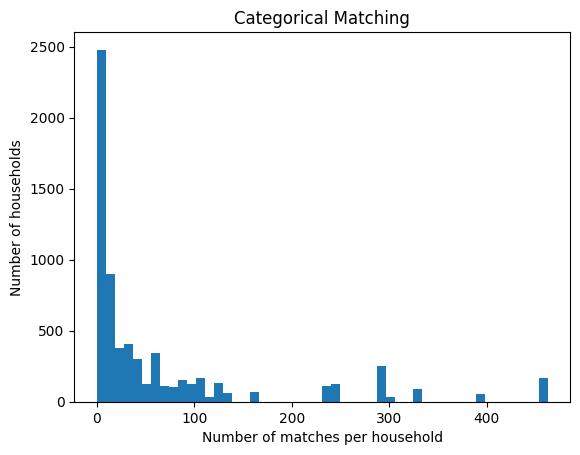

In [34]:
# columns for matching
keys = ['yearly_income', 'number_adults', 'number_children', 'num_pension_age', 
        'employment_status', 'number_cars', 'tenure_status', 'rural_urban_2_categories']


spc_cols = [matching_dfs_dict[key][0] for key in keys]
nts_cols = [matching_dfs_dict[key][1] for key in keys]

# match
spc_nts_1 = spc_matching.merge(nts_matching,
                               left_on= spc_cols,
                               right_on= nts_cols,
                               how = 'left')

# Calculate how many rows from nts_matching are matched onto each hid in spc_matching,
spc_nts_1['count'] = spc_nts_1.groupby('hid')['HouseholdID'].transform('count')

spc_nts_1_hist = spc_nts_1.drop_duplicates(subset='hid')


# plot a histogram of the counts and label the axis and title
plt.hist(spc_nts_1_hist['count'], bins=50)
plt.xlabel('Number of matches per household')
plt.ylabel('Number of households')
plt.title('Categorical Matching')

print(spc_nts_1_hist[spc_nts_1_hist['count'] == 0].shape[0], "households in the SPC had no match")
print(round((spc_nts_1_hist[spc_nts_1_hist['count'] == 0].shape[0] / spc_matching['hid'].unique().shape[0]) * 100, 1), "% of households in the SPC had no match")

In [35]:
# calculate matching coverage for all columns

match_coverage_1 = {key: match_coverage_col(data=spc_nts_1, 
                                            id_x='hid', 
                                            id_y='HouseholdID',
                                            column=matching_dfs_dict[key][0]) 
                    for key in matching_dfs_dict.keys()
            }

# extract any df from the list
match_coverage_1['number_children']



Total  Matched  Percentage Matched
num_children                                    
0              4666   4489.0                96.0
1              1786   1088.0                61.0
2               218    132.0                61.0
3                51     25.0                49.0
4                 4      NaN                 NaN

Attempt 2: Match on a subset of columns (exclude salary)

674 households in the SPC had no match
10.0 % of households in the SPC had no match


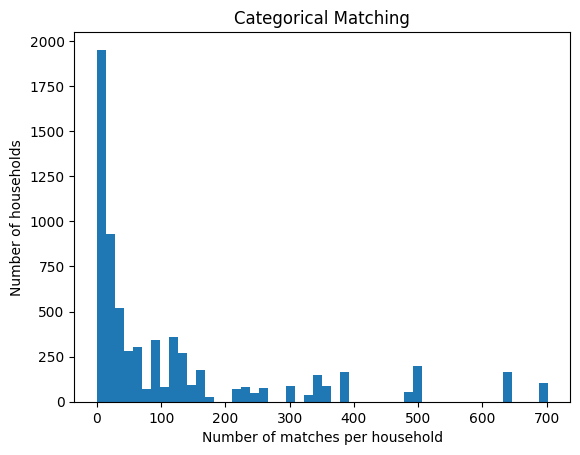

In [36]:
# columns for matching
keys = ['number_adults', 'number_children', 'num_pension_age', 'employment_status', 
        'number_cars', 'tenure_status','rural_urban_2_categories']
# extract equivalent column names from dictionary
spc_cols = [matching_dfs_dict[key][0] for key in keys]
nts_cols = [matching_dfs_dict[key][1] for key in keys]

# match
spc_nts_2 = spc_matching.merge(nts_matching,
                               left_on= spc_cols,
                               right_on= nts_cols,
                               how = 'left')

# Calculate how many rows from nts_matching are matched onto each hid in spc_matching,
spc_nts_2['count'] = spc_nts_2.groupby('hid')['HouseholdID'].transform('count')

spc_nts_2_hist = spc_nts_2.drop_duplicates(subset='hid')


# plot a histogram of the counts and label the axis and title
plt.hist(spc_nts_2_hist['count'], bins=50)
plt.xlabel('Number of matches per household')
plt.ylabel('Number of households')
plt.title('Categorical Matching')


print(spc_nts_2_hist[spc_nts_2_hist['count'] == 0].shape[0], "households in the SPC had no match")
print(round((spc_nts_2_hist[spc_nts_2_hist['count'] == 0].shape[0] / spc_matching['hid'].unique().shape[0]) * 100, 1), "% of households in the SPC had no match")

In [37]:
# calculate matching coverage for all columns

match_coverage_2 = {key: match_coverage_col(data=spc_nts_2, 
                                            id_x='hid', 
                                            id_y='HouseholdID',
                                            column=matching_dfs_dict[key][0]) 
                    for key in matching_dfs_dict.keys()
            }

# extract any df from the list
#match_coverage_2['number_cars']

Attempt 3: Match on a subset of columns (exclude salary and tenure)

547 households in the SPC had no match
8.1 % of households in the SPC had no match


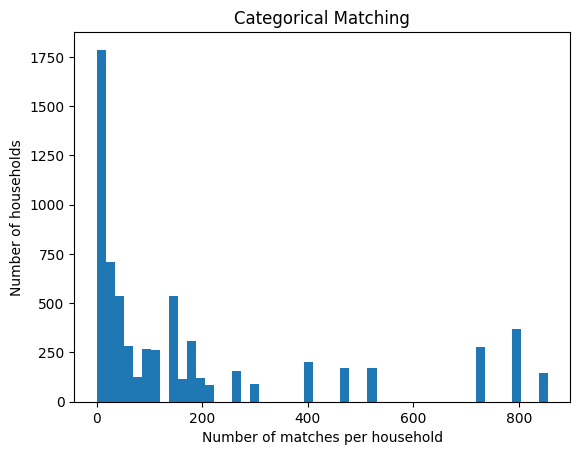

In [38]:

# columns for matching
keys = ['number_adults', 'number_children', 'num_pension_age', 'employment_status', 
        'number_cars', 'rural_urban_2_categories']
# extract equivalent column names from dictionary
spc_cols = [matching_dfs_dict[key][0] for key in keys]
nts_cols = [matching_dfs_dict[key][1] for key in keys]

# matc
spc_nts_3 = spc_matching.merge(nts_matching,
                               left_on= spc_cols,
                               right_on= nts_cols,
                               how = 'left')

# Calculate how many rows from nts_matching are matched onto each hid in spc_matching,
spc_nts_3['count'] = spc_nts_3.groupby('hid')['HouseholdID'].transform('count')

spc_nts_3_hist = spc_nts_3.drop_duplicates(subset='hid')


# plot a histogram of the counts and label the axis and title
plt.hist(spc_nts_3_hist['count'], bins=50)
plt.xlabel('Number of matches per household')
plt.ylabel('Number of households')
plt.title('Categorical Matching')


print(spc_nts_3_hist[spc_nts_3_hist['count'] == 0].shape[0], "households in the SPC had no match")
print(round((spc_nts_3_hist[spc_nts_3_hist['count'] == 0].shape[0] / spc_matching['hid'].unique().shape[0]) * 100, 1), "% of households in the SPC had no match")


In [39]:
# calculate matching coverage for all columns

match_coverage_3 = {key: match_coverage_col(data=spc_nts_3, 
                                            id_x='hid', 
                                            id_y='HouseholdID',
                                            column=matching_dfs_dict[key][0]) 
                    for key in matching_dfs_dict.keys()
            }

# extract any df from the list
#match_coverage_2['number_cars']

Attempt 4: Match on a subset of columns (exclude salary, tenure, and employment status)

266 households in the SPC had no match
4.0 % of households in the SPC had no match


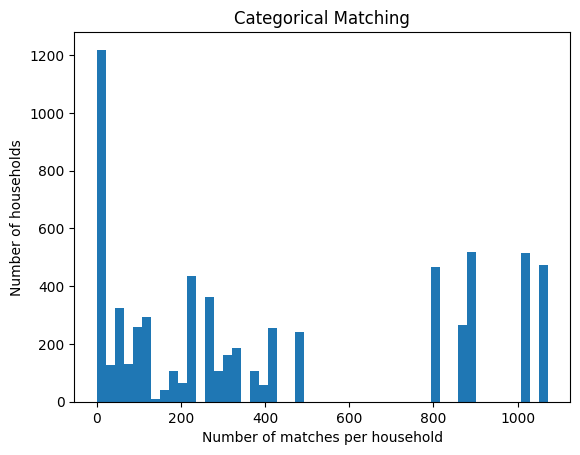

In [40]:

# columns for matching
keys = ['number_adults', 'number_children', 'num_pension_age', 'number_cars', 'rural_urban_2_categories']
# extract equivalent column names from dictionary
spc_cols = [matching_dfs_dict[key][0] for key in keys]
nts_cols = [matching_dfs_dict[key][1] for key in keys]

# matc
spc_nts_4 = spc_matching.merge(nts_matching,
                               left_on= spc_cols,
                               right_on= nts_cols,
                               how = 'left')

# Calculate how many rows from nts_matching are matched onto each hid in spc_matching,
spc_nts_4['count'] = spc_nts_4.groupby('hid')['HouseholdID'].transform('count')

spc_nts_4_hist = spc_nts_4.drop_duplicates(subset='hid')


# plot a histogram of the counts and label the axis and title
plt.hist(spc_nts_4_hist['count'], bins=50)
plt.xlabel('Number of matches per household')
plt.ylabel('Number of households')
plt.title('Categorical Matching')


print(spc_nts_4_hist[spc_nts_4_hist['count'] == 0].shape[0], "households in the SPC had no match")
print(round((spc_nts_4_hist[spc_nts_4_hist['count'] == 0].shape[0] / spc_matching['hid'].unique().shape[0]) * 100, 1), "% of households in the SPC had no match")


In [41]:
# calculate matching coverage for all columns

match_coverage_4 = {key: match_coverage_col(data=spc_nts_4, 
                                            id_x='hid', 
                                            id_y='HouseholdID',
                                            column=matching_dfs_dict[key][0]) 
                    for key in matching_dfs_dict.keys()
            }

# extract any df from the list
#match_coverage_2['number_cars']

Removing salary has a significant impact on matching

In [42]:
print(spc_matching['hid'].nunique(), "Total households in SPC")

# Attempt 1
print(spc_nts_1_hist[spc_nts_1_hist['count'] == 0].shape[0], "Unmatched households - matching on all categories")
# Attempt 2
print(spc_nts_2_hist[spc_nts_2_hist['count'] == 0].shape[0], "Unmatched households - exclusing Salary from matching")
# Attempt 3
print(spc_nts_3_hist[spc_nts_3_hist['count'] == 0].shape[0], "Unmatched households - exclusing Salary and Tenure from matching")
# Attempt 4
print(spc_nts_4_hist[spc_nts_4_hist['count'] == 0].shape[0], "Unmatched households - exclusing Salary, Tenure and Employment status from matching")

6725 Total households in SPC
991 Unmatched households - matching on all categories
674 Unmatched households - exclusing Salary from matching
547 Unmatched households - exclusing Salary and Tenure from matching
266 Unmatched households - exclusing Salary, Tenure and Employment status from matching


Plot matching coverage for each attempt + variable (key) combination

This will show us, for each matching key, the % of spc households from each unique category that were matched to the NTS

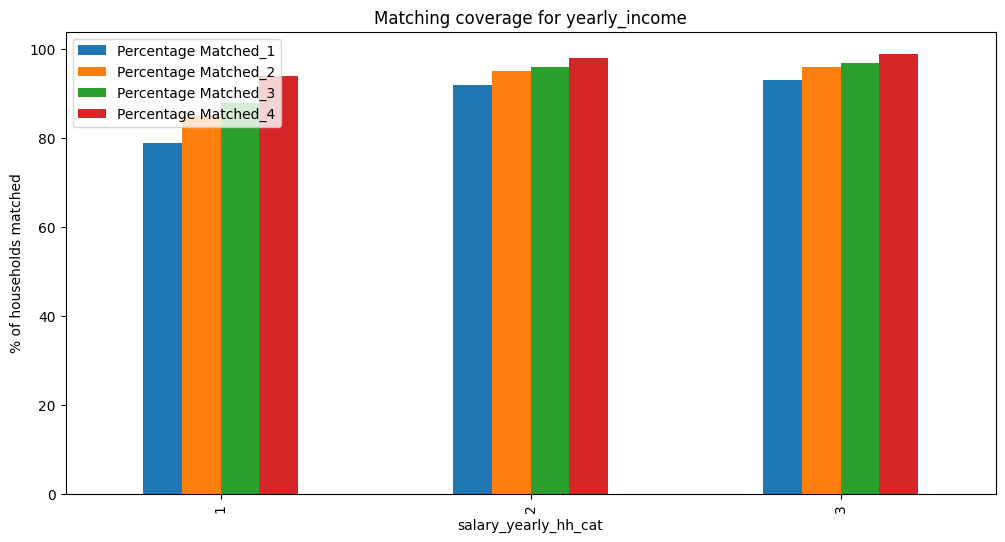

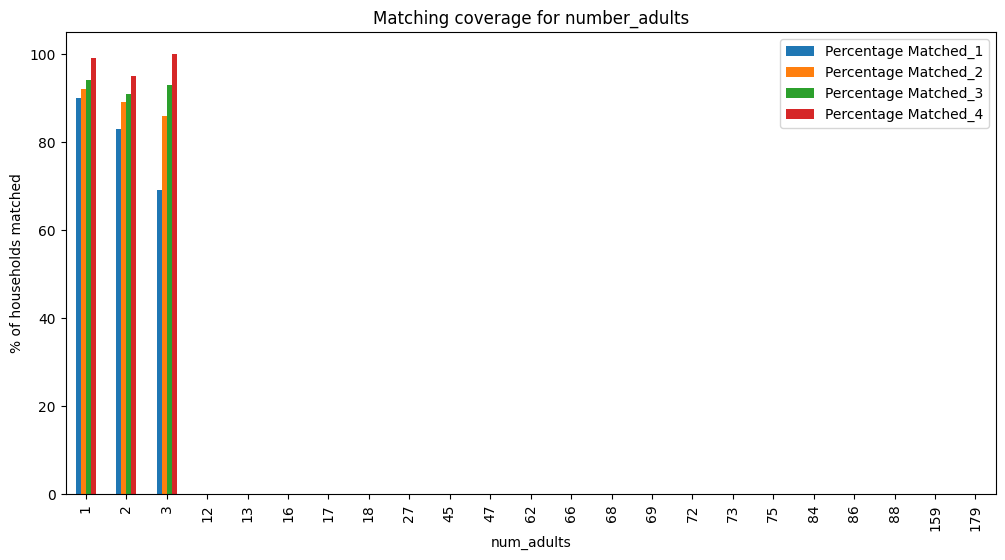

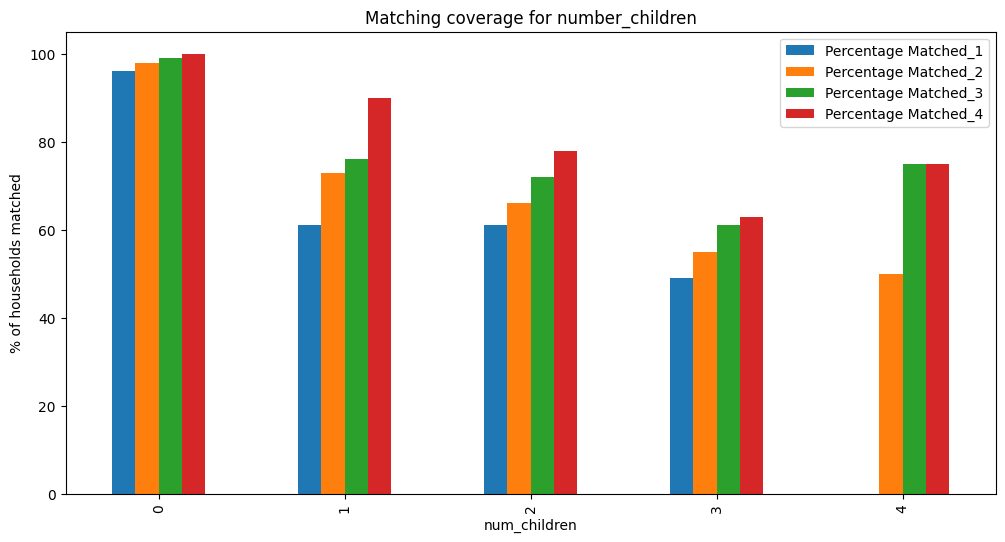

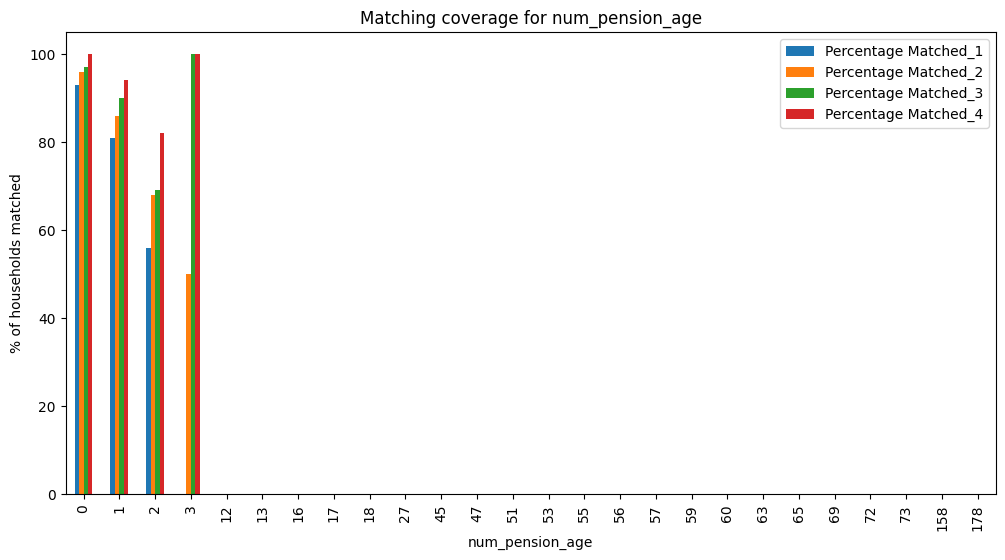

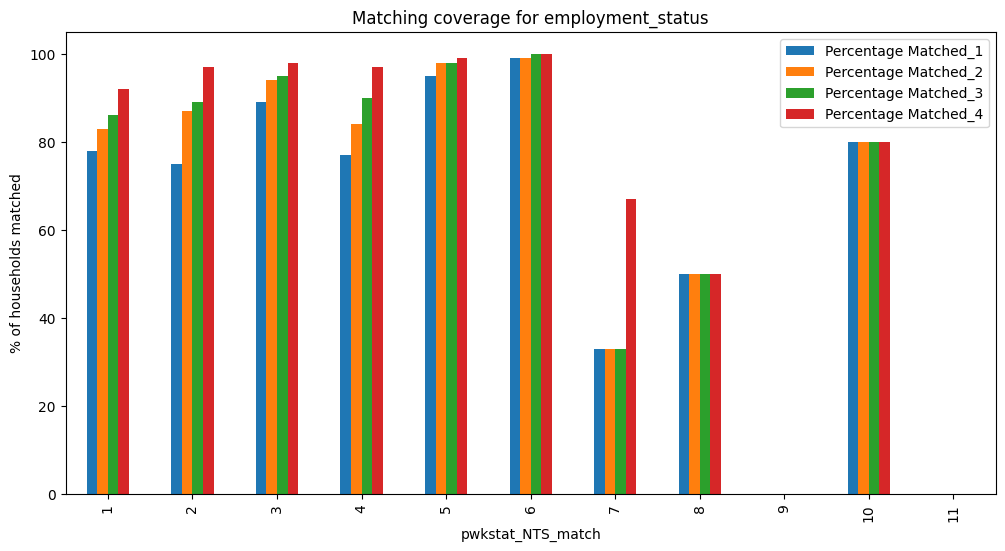

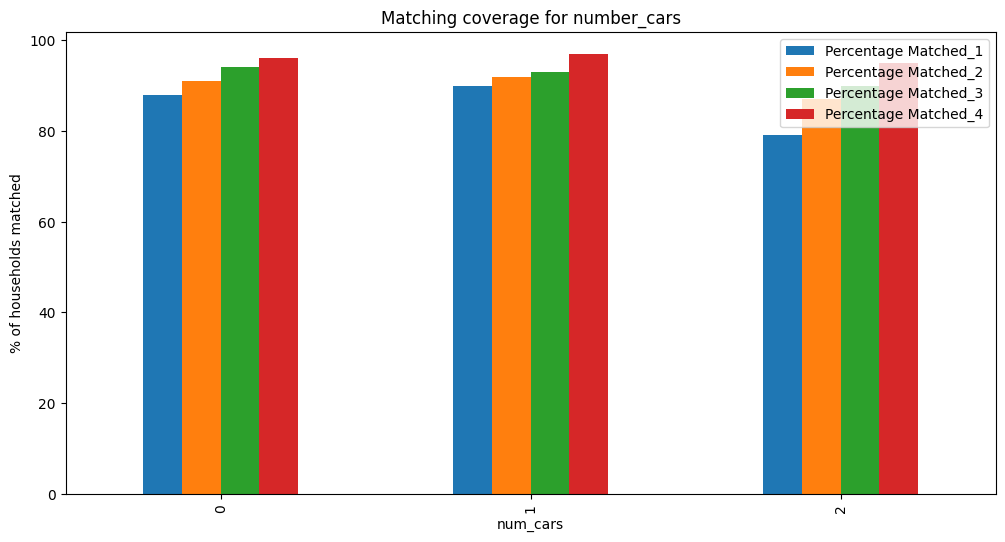

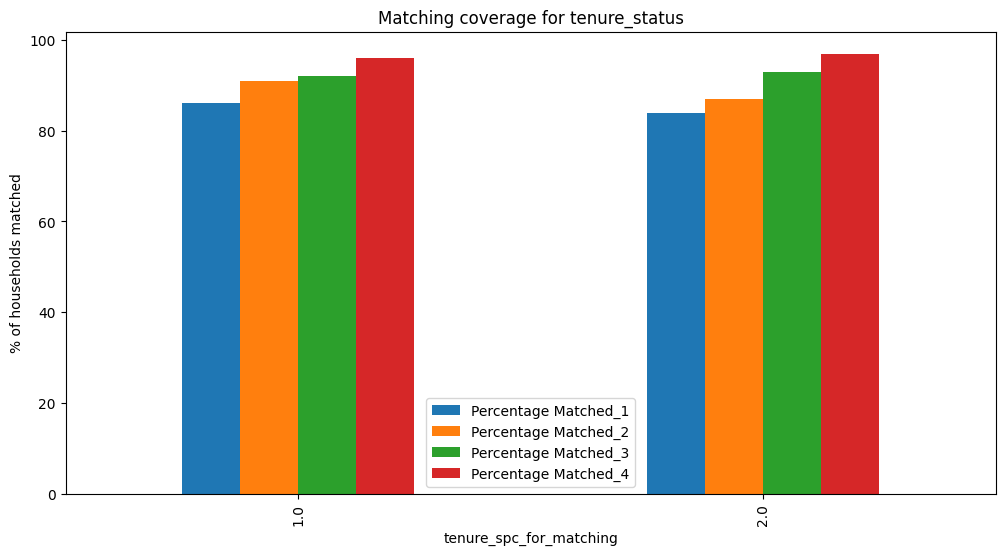

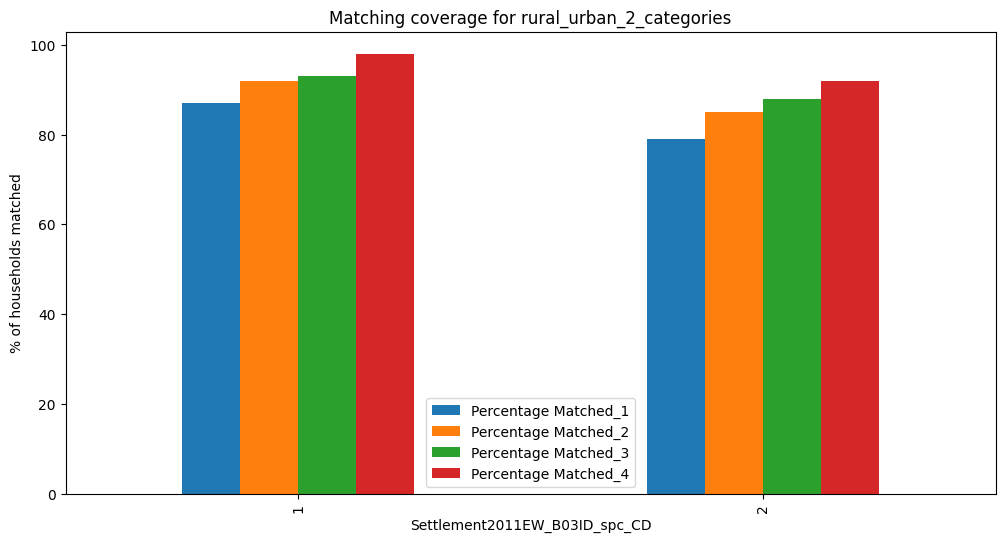

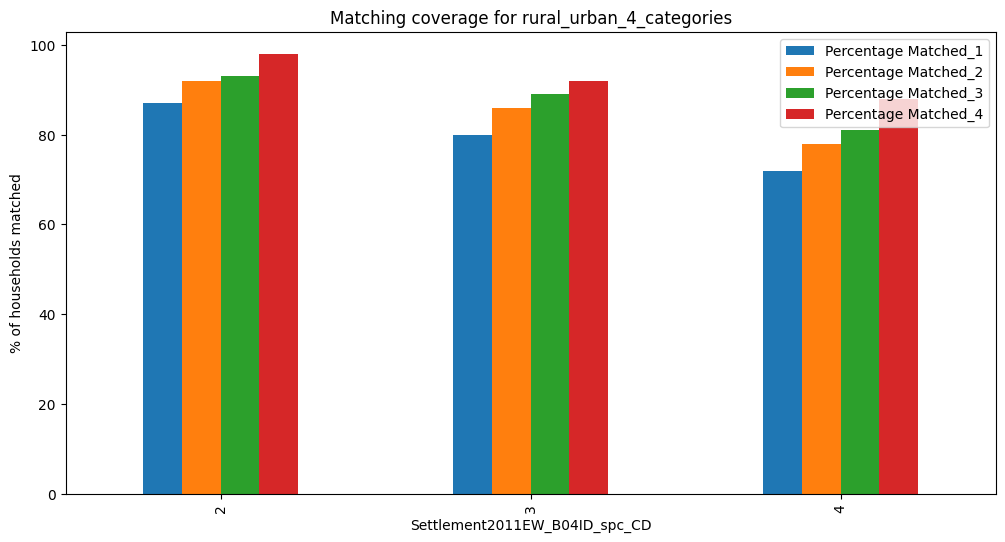

In [43]:
# loop over all variables in matching_dfs_dict and save a plot for each
for key in list(matching_dfs_dict.keys())[1:]:      # skip 1st key (hid)
    x = (match_coverage_1[key]
     .merge(match_coverage_2[key], on=matching_dfs_dict[key][0], suffixes=('_1', '_2'))
     .merge(match_coverage_3[key], on=matching_dfs_dict[key][0], suffixes=('_2', '_3'))
     .merge(match_coverage_4[key], on=matching_dfs_dict[key][0], suffixes=('_3', '_4')))
    # keep % columns only 
    x = x[[col for col in x.columns if 'Percentage' in col]]
    # plot bar chart of Percentage of households matched for each category
    fig, ax = plt.subplots(1, 1, figsize=(12, 6))
    x.plot(kind='bar', ax=ax)
    plt.ylabel('% of households matched')
    plt.title('Matching coverage for ' + key)
    plt.show()
    # save the plot
    fig.savefig(f'../data/interim/matching/plots/matching_coverage_hh_{key}.png')
    

    


#### Treat different households differently

Salary is a useful matching variable, so it's a shame not to use it all. We can try to:
- match on salary for households with 0 pensioners
- match without salary for households with one or more pensioners 

493 households in the SPC had no match
7.3 % of households in the SPC had no match


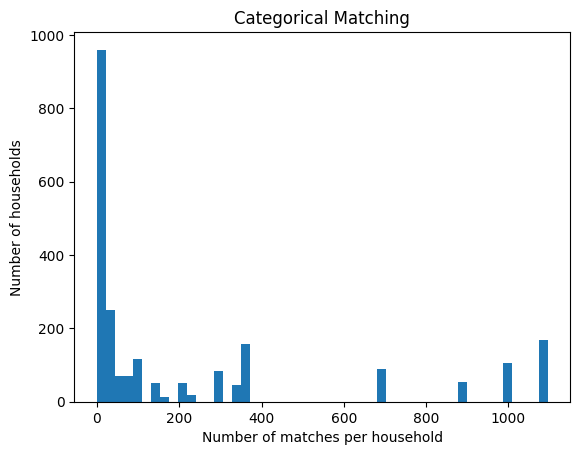

In [44]:
# match on different subset of column depending on yearly_income value
keys = ['yearly_income', 'number_adults', 'number_children', 'num_pension_age', 
        'employment_status', 'number_cars', 'tenure_status', 'rural_urban_2_categories']
# remove yearly income from the list
# new list without yearly income, without modifying the original list
keys_no_salary = keys.copy()
keys_no_salary.remove('yearly_income')


#### ------ Split the two datasets into households with no salary and households with a salary

# get spc column name that matches yearly_income in matching_dfs_dict
spc_col = matching_dfs_dict['num_pension_age'][0]
nts_col = matching_dfs_dict['num_pension_age'][1]

# dfs: households with no salary
spc_matching_no_salary = spc_matching[spc_matching[spc_col] > 0]
nts_matching_no_salary = nts_matching[nts_matching[nts_col] > 0]

# dfs: households with a salary
spc_matching_salary = spc_matching[spc_matching[spc_col] != 0]
nts_matching_salary = nts_matching[nts_matching[nts_col] != 0]


#### ------ Match the two datasets separately

# extract equivalent column names from dictionary
spc_cols = [matching_dfs_dict[key][0] for key in keys]
nts_cols = [matching_dfs_dict[key][1] for key in keys]

# extract equivalent column names from dictionary
spc_cols_no_salary = [matching_dfs_dict[key][0] for key in keys_no_salary]
nts_cols_no_salary = [matching_dfs_dict[key][1] for key in keys_no_salary]

# match
spc_nts_no_salary = spc_matching_no_salary.merge(nts_matching_no_salary,
                                                 left_on= spc_cols_no_salary,
                                                 right_on= nts_cols_no_salary,
                                                 how = 'left')

spc_nts_salary = spc_matching_salary.merge(nts_matching_salary,
                                           left_on= spc_cols,
                                           right_on= nts_cols,
                                           how = 'left')

# bind the rows of the two dataframes
spc_nts_x = pd.concat([spc_nts_no_salary, spc_nts_salary])


# Calculate how many rows from nts_matching are matched onto each hid in spc_matching,
spc_nts_x['count'] = spc_nts_x.groupby('hid')['HouseholdID'].transform('count')

spc_nts_x_hist = spc_nts_x.drop_duplicates(subset='hid')


# plot a histogram of the counts and label the axis and title
plt.hist(spc_nts_x_hist['count'], bins=50)
plt.xlabel('Number of matches per household')
plt.ylabel('Number of households')
plt.title('Categorical Matching')


print(spc_nts_x_hist[spc_nts_x_hist['count'] == 0].shape[0], "households in the SPC had no match")
print(round((spc_nts_x_hist[spc_nts_x_hist['count'] == 0].shape[0] / spc_matching['hid'].unique().shape[0]) * 100, 1), "% of households in the SPC had no match")


Store the results in a dictionary, 

- Key: SPC hid
- Value: List of NTS Household IDs



In [45]:
# Each hid in spc_matching is joined onto multiple HouseholdID in nts_matching.
# Create a dictionary to store the hid to HouseholdID matches

def extract_matching_results(df: pd.DataFrame, key_col: str, value_col: str) -> dict:
    '''
    Extracts a dictionary where each key can be associated with multiple values

    Parameters
    ----------
    df : DataFrame
        The DataFrame to extract the matching results from
    key_col : str
        The name of the column to use as the key
    value_col : str
        The name of the column to use as the value

    Returns
    -------
    dict
        A dictionary where each key can be associated with multiple values
    '''
    matching_results = df.groupby(key_col)[value_col].apply(list).to_dict()
    return matching_results

In [46]:
matches_hh_level = extract_matching_results(df = spc_nts_4,
                                            key_col = 'hid',
                                            value_col = 'HouseholdID')

In [47]:
# print the 6th key, value in the matches_hh_level dictionary
print(list(matches_hh_level.items())[90])

('E02002183_0091', [2019001902.0, 2019004101.0, 2019004092.0, 2019004108.0, 2019004125.0, 2019004121.0, 2019001719.0, 2019001714.0, 2019001119.0, 2019001130.0, 2019001148.0, 2019000880.0, 2019003240.0, 2019002767.0, 2019002775.0, 2019002769.0, 2019005597.0, 2019002770.0, 2019003252.0, 2019005438.0, 2019006462.0, 2019006475.0, 2019003208.0, 2019004196.0, 2019004191.0, 2019004200.0, 2019004197.0, 2019000839.0, 2019000350.0, 2019000855.0, 2019001091.0, 2019001721.0, 2019001716.0, 2019000813.0, 2019004159.0, 2019000823.0, 2019004177.0, 2019001167.0, 2019000633.0, 2019000536.0, 2019005323.0, 2019005356.0, 2019004637.0, 2019005612.0, 2019002547.0, 2019005638.0, 2019001816.0, 2019002329.0, 2019002894.0, 2019001865.0, 2019003329.0, 2019002919.0, 2019002929.0, 2019005553.0, 2019000307.0, 2019004714.0, 2019002980.0, 2019001202.0, 2019001205.0, 2019001210.0, 2019001782.0, 2019001788.0, 2019002721.0, 2019005579.0, 2019000863.0, 2019001896.0, 2019001909.0, 2019000589.0, 2019000701.0, 2019002368.0, 

In [48]:
## add matches_hh_level as a column in spc_edited
spc_edited['nts_hh_id'] = spc_edited['hid'].map(matches_hh_level)

spc_edited.head(5)

id  household                                           location   pid_hs  \
0   0          0  {'x': -1.7892179489135742, 'y': 53.91915130615...  2905399   
1   1          1  {'x': -1.8262380361557007, 'y': 53.92028045654...  2905308   
2   2          1  {'x': -1.8262380361557007, 'y': 53.92028045654...  2907681   
3   3          2  {'x': -1.8749940395355225, 'y': 53.94298934936...  2902817   
4   4          2  {'x': -1.8749940395355225, 'y': 53.94298934936...  2900884   

        msoa         oa members sic1d2007  sic2d2007  pwkstat  salary_yearly  \
0  E02002183  E00053954     [0]         J       58.0        6            NaN   
1  E02002183  E00053953  [1, 2]         C       25.0        6            NaN   
2  E02002183  E00053953  [1, 2]         P       85.0        6            NaN   
3  E02002183  E00053689  [3, 4]         C       31.0        1   32857.859375   
4  E02002183  E00053689  [3, 4]         J       62.0        1   18162.451172   

   salary_hourly             hid  accommodation_type  communal_type  \
0            NaN  E02002183_0001                 1.0            NaN   
1            NaN  E02002183_0002                 3.0            NaN   
2            NaN  E02002183_0002                 3.0            NaN   
3      14.360952  E02002183_0003                 3.0            NaN   
4       9.439944  E02002183_0003                 3.0            NaN   

   num_rooms  central_heat  tenure  num_cars  sex  age_years  ethnicity  \
0        2.0          True     2.0         2    1         86          1   
1        6.0          True     2.0         2    1         74          3   
2        6.0          True     2.0         2    2         68          1   
3        6.0          True     2.0         1    1         27          1   
4        6.0          True     2.0         1    2         26          1   

   nssec8  salary_yearly_hh  salary_yearly_hh_cat  is_adult  num_adults  \
0     1.0          0.000000                     1         1           1   
1     1.0          0.000000                     1         1           2   
2     2.0          0.000000                     1         1           2   
3     4.0      51020.310547                     3         1           2   
4     6.0      51020.310547                     3         1           2   

   is_child  num_children  is_pension_age  num_pension_age  pwkstat_FT_hh  \
0         0             0               1                1              0   
1         0             0               1                2              0   
2         0             0               1                2              0   
3         0             0               0                0              2   
4         0             0               0                0              2   

   pwkstat_PT_hh  pwkstat_NTS_match     OA11CD                  RUC11 RUC11CD  \
0              0                  1  E00053954    Urban city and town      C1   
1              0                  1  E00053953    Urban city and town      C1   
2              0                  1  E00053953    Urban city and town      C1   
3              0                  6  E00053689  Rural town and fringe      D1   
4              0                  6  E00053689  Rural town and fringe      D1   

  Settlement2011EW_B03ID_spc Settlement2011EW_B04ID_spc  \
0                      Urban        Urban City and Town   
1                      Urban        Urban City and Town   
2                      Urban        Urban City and Town   
3                      Rural      Rural Town and Fringe   
4                      Rural      Rural Town and Fringe   

   Settlement2011EW_B03ID_spc_CD  Settlement2011EW_B04ID_spc_CD  \
0                              1                              2   
1                              1                              2   
2                              1                              2   
3                              2                              3   
4                              2                              3   

   t

### Random Sampling from matched households

In categorical matching, many households in the SPC are matched to more than 1 household in the NTS. Which household to choose? We do random sampling

In [49]:
# for each key in the dictionary, sample 1 of the values associated with it and store it in a new dictionary

'''
- iterate over each key-value pair in the matches_hh_result dictionary.
- For each key-value pair, use np.random.choice(value) to randomly select 
one item from the list of values associated with the current key.
- create a new dictionary hid_to_HouseholdID_sample where each key from the 
original dictionary is associated with one randomly selected value from the 
original list of values.

'''
matches_hh_level_sample = {key: np.random.choice(value) for key, value in matches_hh_level.items()}

# remove items in list where value is nan
matches_hh_level_sample = {key: value for key, value in matches_hh_level_sample.items() if not pd.isna(value)}


In [50]:
print(list(matches_hh_level_sample.items())[568])

('E02002183_0595', 2022001600.0)


Multiple matches in case we want to try stochastic runs

In [51]:
# same logic as cell above, but repeat it multiple times and store each result as a separate dictionary in a list
matches_hh_level_sample_list = [{key: np.random.choice(value) for key, value in matches_hh_level.items()} for i in range(100)]

matches_hh_level_sample_list

[{'E02002183_0001': 2022000721.0,
  'E02002183_0002': 2021003376.0,
  'E02002183_0003': 2021003750.0,
  'E02002183_0004': 2019006468.0,
  'E02002183_0005': nan,
  'E02002183_0006': 2021003975.0,
  'E02002183_0007': 2019006542.0,
  'E02002183_0008': 2022000246.0,
  'E02002183_0009': 2022000059.0,
  'E02002183_0010': 2019004840.0,
  'E02002183_0011': 2021002201.0,
  'E02002183_0012': 2021000332.0,
  'E02002183_0013': 2021003812.0,
  'E02002183_0014': 2019003195.0,
  'E02002183_0015': 2019003895.0,
  'E02002183_0016': 2021000302.0,
  'E02002183_0017': 2019002371.0,
  'E02002183_0018': 2021003747.0,
  'E02002183_0019': 2019000379.0,
  'E02002183_0020': 2022003901.0,
  'E02002183_0021': 2021003118.0,
  'E02002183_0022': 2019006455.0,
  'E02002183_0023': 2019003117.0,
  'E02002183_0024': 2022001880.0,
  'E02002183_0025': 2019005269.0,
  'E02002183_0026': 2019001219.0,
  'E02002183_0027': 2019005739.0,
  'E02002183_0028': 2019000322.0,
  'E02002183_0029': 2019002914.0,
  'E02002183_0030': nan

Save results

In [52]:
# random sample 
with open('../data/interim/matching/matches_hh_level_categorical_random_sample.pkl', 'wb') as f:
    pkl.dump(matches_hh_level_sample, f)

# multiple random samples
with open('../data/interim/matching/matches_hh_level_categorical_random_sample_multiple.pkl', 'wb') as f:
    pkl.dump(matches_hh_level_sample_list, f)

Do the same at the df level. Add nts_hh_id_sample column to the spc df

In [ ]:
# # for each hid in spc_edited, sample a value from the nts_hh_id col. 
# spc_edited['nts_hh_id_sample'] = spc_edited['nts_hh_id'].apply(lambda x: np.random.choice(x) if x is not np.nan else np.nan)
# # All rows with the same 'hid' should have the same value for 'nts_hh_id_sample'. Group by hid and assign the first value to all rows in the group
# spc_edited['nts_hh_id_sample'] = spc_edited.groupby('hid')['nts_hh_id_sample'].transform('first')

# spc_edited.head(10)

## Step 4: Matching at Individual Level

1) Prepare columns for matching - they should all be numerical
    a) age_years in the SPC -> Convert from actual age to age brackets from the dictionary
2) Filter to specific household
3) Nearest neighbor merge without replacement (edit while function below)



In [53]:
nts_individuals_filtered.head()

IndividualID  HouseholdID       PSUID  Age_B01ID  Age_B04ID  \
340872    2019005376   2019002277  2019000253          4          2   
340873    2019005377   2019002278  2019000253         12          5   
340874    2019005378   2019002278  2019000253         13          6   
340875    2019005379   2019002279  2019000253         20          9   
340876    2019005380   2019002280  2019000253         13          6   

        Sex_B01ID  OfPenAge_B01ID  HRPRelation_B01ID  EdAttn1_B01ID  \
340872          1               2                  3             -9   
340873          2               2                 99              1   
340874          1               2                  2              1   
340875          2               1                 99              1   
340876          1               2                 99              1   

        EdAttn2_B01ID  EdAttn3_B01ID  OwnCycle_B01ID  DrivLic_B02ID  \
340872             -9             -9             -10             -9   
340873             -9             -9             -10              1   
340874             -9             -9             -10              1   
340875             -9             -9             -10              3   
340876             -9             -9             -10              1   

        CarAccess_B01ID  IndIncome2002_B02ID  IndWkGOR_B02ID  EcoStat_B02ID  \
340872                4                   -9            -9.0             -9   
340873                2                    3             8.0              1   
340874                2                    3             7.0              1   
340875                6                    1            -9.0              4   
340876                5                    2            -9.0              1   

        EcoStat_B03ID  NSSec_B03ID  SC_B01ID  Stat_B01ID  WkMode_B01ID  \
340872             -9           -9        -9          -9            -9   
340873              1            1         1           1             1   
340874              1            1         2           1             8   
340875              3            3         3           1            -9   
340876              1            3         4           1             1   

        WkHome_B01ID  PossHom_B01ID  OftHome_B01ID  TravSh_B01ID  \
340872           -10            -10             -9           -10   
340873           -10            -10              2           -10   
340874           -10            -10              7           -10   
340875           -10            -10             -9           -10   
340876           -10            -10              7           -10   

        SchDly_B01ID  SchTrav_B01ID  SchAcc_B01ID  FdShp_B01ID  
340872             1              9             1          -10  
340873            -9             -9            -9          -10  
340874            -9             -9            -9          -10  
340875            -9             -9            -9          -10  
340876            -9             -9            -9          -10

Create an 'age' column in the SPC that matches the NTS categories

In [54]:
# create a dictionary for reference on how the labels for "Age_B04ID" match the actual age brackets

# dict_nts_ind_age = {-10: 'DEAD',
#                     -8: 'NA',
#                     1: '0-4',
#                     2: '5-10',
#                     3: '11-16',
#                     4: '17-20',
#                     5: '21-29',
#                     6: '30-39',
#                     7: '40-49',
#                     8: '50-59',
#                     9: '60+'
#                     }


# Define the bins and labels based on dict_nts_ind_age
bins = [0, 4, 10, 16, 20, 29, 39, 49, 59, np.inf]
labels = [1, 2, 3, 4, 5, 6, 7, 8, 9]

# Create a new column in spc_edited that maps the age_years to the keys of dict_nts_ind_age
spc_edited['age_group'] = (pd.cut(spc_edited['age_years'], bins=bins, labels=labels)
                     .astype('int')
                     .fillna(-8))

In [55]:
# rename nts columns in preparation for matching

nts_individuals_filtered.rename(columns={'Age_B04ID': 'age_group', 'Sex_B01ID': 'sex'}, inplace=True)

/tmp/ipykernel_368122/400388732.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  nts_individuals_filtered.rename(columns={'Age_B04ID': 'age_group', 'Sex_B01ID': 'sex'}, inplace=True)


PSM matching using internal match_individuals function

In [56]:
matches_ind = match_individuals(
    df1 = spc_edited, 
    df2 = nts_individuals_filtered,
    matching_columns = ['age_group', 'sex'],
    df1_id = 'hid', 
    df2_id = 'HouseholdID',
    matches_hh = matches_hh_level_sample,
    show_progress = True)

matches_ind


Matching for household 1 out of: 6459
Matching for household 2 out of: 6459
Matching for household 3 out of: 6459
Matching for household 4 out of: 6459
Matching for household 5 out of: 6459
Matching for household 6 out of: 6459
Matching for household 7 out of: 6459
Matching for household 8 out of: 6459
Matching for household 9 out of: 6459
Matching for household 10 out of: 6459
Matching for household 11 out of: 6459
Matching for household 12 out of: 6459
Matching for household 13 out of: 6459
Matching for household 14 out of: 6459
Matching for household 15 out of: 6459
Matching for household 16 out of: 6459
Matching for household 17 out of: 6459
Matching for household 18 out of: 6459
Matching for household 19 out of: 6459
Matching for household 20 out of: 6459
Matching for household 21 out of: 6459
Matching for household 22 out of: 6459
Matching for household 23 out of: 6459
Matching for household 24 out of: 6459
Matching for household 25 out of: 6459
Matching for household 26 out of: 

{0: 376668,
 1: 343034,
 2: 343033,
 3: 374697,
 4: 374698,
 5: 346229,
 9: 374336,
 10: 354879,
 11: 354878,
 12: 354880,
 13: 366024,
 14: 350859,
 15: 350860,
 18: 340889,
 16: 340887,
 17: 340888,
 21: 378599,
 19: 378598,
 20: 378597,
 22: 370489,
 23: 370490,
 25: 348195,
 24: 348196,
 26: 372256,
 28: 376212,
 27: 376213,
 29: 371313,
 30: 378671,
 31: 378670,
 33: 349780,
 34: 349781,
 32: 349779,
 35: 383823,
 36: 383822,
 37: 383824,
 38: 381023,
 39: 382983,
 40: 382982,
 43: 373961,
 42: 373959,
 41: 373960,
 44: 366711,
 45: 352600,
 46: 352601,
 47: 379889,
 48: 370028,
 49: 370029,
 50: 353949,
 51: 380547,
 52: 380548,
 53: 381023,
 56: 382543,
 57: 379057,
 58: 356330,
 59: 356332,
 60: 356331,
 61: 352538,
 63: 352540,
 62: 352539,
 64: 379856,
 65: 379857,
 66: 379858,
 69: 378544,
 68: 378542,
 67: 378543,
 70: 382349,
 71: 382350,
 72: 351804,
 73: 342584,
 75: 377809,
 74: 377810,
 76: 348747,
 77: 348748,
 78: 348749,
 79: 355620,
 80: 369136,
 81: 369137,
 82: 3

In [57]:
# Add matches_ind values to spc_edited using map
spc_edited['nts_ind_id'] = spc_edited.index.map(matches_ind)

# add the nts_individuals_filtered.IndividualID to spc_edit. The current nts_ind_id is the row index of nts_individuals_filtered
spc_edited['nts_ind_id'] = spc_edited['nts_ind_id'].map(nts_individuals_filtered['IndividualID'])


In [58]:
spc_edited.head(5)

id  household                                           location   pid_hs  \
0   0          0  {'x': -1.7892179489135742, 'y': 53.91915130615...  2905399   
1   1          1  {'x': -1.8262380361557007, 'y': 53.92028045654...  2905308   
2   2          1  {'x': -1.8262380361557007, 'y': 53.92028045654...  2907681   
3   3          2  {'x': -1.8749940395355225, 'y': 53.94298934936...  2902817   
4   4          2  {'x': -1.8749940395355225, 'y': 53.94298934936...  2900884   

        msoa         oa members sic1d2007  sic2d2007  pwkstat  salary_yearly  \
0  E02002183  E00053954     [0]         J       58.0        6            NaN   
1  E02002183  E00053953  [1, 2]         C       25.0        6            NaN   
2  E02002183  E00053953  [1, 2]         P       85.0        6            NaN   
3  E02002183  E00053689  [3, 4]         C       31.0        1   32857.859375   
4  E02002183  E00053689  [3, 4]         J       62.0        1   18162.451172   

   salary_hourly             hid  accommodation_type  communal_type  \
0            NaN  E02002183_0001                 1.0            NaN   
1            NaN  E02002183_0002                 3.0            NaN   
2            NaN  E02002183_0002                 3.0            NaN   
3      14.360952  E02002183_0003                 3.0            NaN   
4       9.439944  E02002183_0003                 3.0            NaN   

   num_rooms  central_heat  tenure  num_cars  sex  age_years  ethnicity  \
0        2.0          True     2.0         2    1         86          1   
1        6.0          True     2.0         2    1         74          3   
2        6.0          True     2.0         2    2         68          1   
3        6.0          True     2.0         1    1         27          1   
4        6.0          True     2.0         1    2         26          1   

   nssec8  salary_yearly_hh  salary_yearly_hh_cat  is_adult  num_adults  \
0     1.0          0.000000                     1         1           1   
1     1.0          0.000000                     1         1           2   
2     2.0          0.000000                     1         1           2   
3     4.0      51020.310547                     3         1           2   
4     6.0      51020.310547                     3         1           2   

   is_child  num_children  is_pension_age  num_pension_age  pwkstat_FT_hh  \
0         0             0               1                1              0   
1         0             0               1                2              0   
2         0             0               1                2              0   
3         0             0               0                0              2   
4         0             0               0                0              2   

   pwkstat_PT_hh  pwkstat_NTS_match     OA11CD                  RUC11 RUC11CD  \
0              0                  1  E00053954    Urban city and town      C1   
1              0                  1  E00053953    Urban city and town      C1   
2              0                  1  E00053953    Urban city and town      C1   
3              0                  6  E00053689  Rural town and fringe      D1   
4              0                  6  E00053689  Rural town and fringe      D1   

  Settlement2011EW_B03ID_spc Settlement2011EW_B04ID_spc  \
0                      Urban        Urban City and Town   
1                      Urban        Urban City and Town   
2                      Urban        Urban City and Town   
3                      Rural      Rural Town and Fringe   
4                      Rural      Rural Town and Fringe   

   Settlement2011EW_B03ID_spc_CD  Settlement2011EW_B04ID_spc_CD  \
0                              1                              2   
1                              1                              2   
2                              1                              2   
3                              2                              3   
4                              2                              3   

   t

### Check that matching is working as intended

In [59]:
#ids = [99, 100, 101, 102]
ids = [109, 110, 111, 112, 113, 114]


spc_rows = []
nts_rows = []

for id in ids:
    # get spc and nts values for position id
    spc_ind = list(matches_ind.keys())[id]
    nts_ind = matches_ind[list(matches_ind.keys())[id]]

    # get rows from spc and nts dfs that match spc_ind and nts_ind
    spc_row = spc_edited.loc[spc_ind]
    nts_row = nts_individuals_filtered.loc[nts_ind]

    # convert to df and append
    spc_rows.append(spc_row.to_frame().transpose())
    nts_rows.append(nts_row.to_frame().transpose())
# convert individual dfs to one df
spc_rows_df = pd.concat(spc_rows)
nts_rows_df = pd.concat(nts_rows)
    

spc_rows_df


id household                                           location  \
117  117        61  {'x': -1.887002944946289, 'y': 53.944278717041...   
118  118        62  {'x': -1.8956769704818726, 'y': 53.94247055053...   
119  119        62  {'x': -1.8956769704818726, 'y': 53.94247055053...   
121  121        63  {'x': -1.7892179489135742, 'y': 53.91915130615...   
120  120        63  {'x': -1.7892179489135742, 'y': 53.91915130615...   
122  122        64  {'x': -1.8792779445648193, 'y': 53.94593048095...   

      pid_hs       msoa         oa     members sic1d2007 sic2d2007 pwkstat  \
117  2904126  E02002183  E00053688  [116, 117]         G      47.0      10   
118  2908490  E02002183  E00053691  [118, 119]         J      61.0       1   
119  2911873  E02002183  E00053691  [118, 119]         M      70.0       4   
121  2904728  E02002183  E00053954  [120, 121]         C      14.0       4   
120  2911879  E02002183  E00053954  [120, 121]         C      27.0       1   
122  2910111  E02002183  E00053696       [122]         M      71.0       1   

    salary_yearly salary_hourly             hid accommodation_type  \
117           NaN           NaN  E02002183_0062                3.0   
118  18557.246094      9.391318  E02002183_0063                1.0   
119           NaN           NaN  E02002183_0063                1.0   
121           NaN           NaN  E02002183_0064                4.0   
120  53864.953125     25.896612  E02002183_0064                4.0   
122  51522.851562     24.770601  E02002183_0065                2.0   

    communal_type num_rooms central_heat tenure num_cars sex age_years  \
117           NaN       4.0         True    5.0        2   1        71   
118           NaN       5.0         True    1.0        1   1        30   
119           NaN       5.0         True    1.0        1   2        29   
121           NaN       6.0         True    1.0        2   2        42   
120           NaN       6.0         True    1.0        2   1        42   
122           NaN       3.0         True    4.0        1   1        53   

    ethnicity nssec8 salary_yearly_hh salary_yearly_hh_cat is_adult  \
117         1    1.0      5020.788086                    1        1   
118         1    4.0     18557.246094                    1        1   
119         1    2.0     18557.246094                    1        1   
121         1    5.0     53864.953125                    3        1   
120         1    1.0     53864.953125                    3        1   
122         3    2.0     51522.851562                    3        1   

    num_adults is_child num_children is_pension_age num_pension_age  \
117          2        0            0              1               2   
118          2        0            0              0               0   
119          2        0            0              0               0   
121          2        0            0              0               0   
120          2        0            0              0               0   
122          1        0            0              0               0   

    pwkstat_FT_hh pwkstat_PT_hh pwkstat_NTS_match     OA11CD  \
117             0             1                 2  E00053688   
118             1             0                 3  E00053691   
119             1             0                 3  E00053691   
121             1             0                 3  E00053954   
120             1             0                 3  E00053954   
122             1             0                 3  E00053696   

                     RUC11 RUC11CD Settlement2011EW_B03ID_spc  \
117  Rural town and fringe      D1                      Rural   
118  Rural town and fringe      D1                      Rural   
119  Rural town and fringe      D1                      Rural   
121    Urban city and town      C1                      Urban   
120    Urban city and town      C1                      Urban   
122  Rural town and fringe      D1                      Rural   

    Settlement2011EW_B04ID_spc Settl

In [60]:
from IPython.display import display

display(spc_rows_df[['id', 'household', 'pwkstat', 'salary_yearly', 'salary_hourly', 'hid',
       'tenure', 'num_cars', 'sex', 'age_years','age_group', 'nssec8', 'salary_yearly_hh', 
       'salary_yearly_hh_cat', 'is_adult','is_child', 'is_pension_age','pwkstat_FT_hh', 'pwkstat_PT_hh', 
       'pwkstat_NTS_match', 'Settlement2011EW_B03ID_spc',
       'Settlement2011EW_B04ID_spc', 'Settlement2011EW_B03ID_spc_CD', 'Settlement2011EW_B04ID_spc_CD']])

display(nts_rows_df[['IndividualID', 'HouseholdID', 'Age_B01ID', 'age_group', 'sex','OfPenAge_B01ID', 'IndIncome2002_B02ID']])

id household pwkstat salary_yearly salary_hourly             hid tenure  \
117  117        61      10           NaN           NaN  E02002183_0062    5.0   
118  118        62       1  18557.246094      9.391318  E02002183_0063    1.0   
119  119        62       4           NaN           NaN  E02002183_0063    1.0   
121  121        63       4           NaN           NaN  E02002183_0064    1.0   
120  120        63       1  53864.953125     25.896612  E02002183_0064    1.0   
122  122        64       1  51522.851562     24.770601  E02002183_0065    4.0   

    num_cars sex age_years age_group nssec8 salary_yearly_hh  \
117        2   1        71         9    1.0      5020.788086   
118        1   1        30         6    4.0     18557.246094   
119        1   2        29         5    2.0     18557.246094   
121        2   2        42         7    5.0     53864.953125   
120        2   1        42         7    1.0     53864.953125   
122        1   1        53         8    2.0     51522.851562   

    salary_yearly_hh_cat is_adult is_child is_pension_age pwkstat_FT_hh  \
117                    1        1        0              1             0   
118                    1        1        0              0             1   
119                    1        1        0              0             1   
121                    3        1        0              0             1   
120                    3        1        0              0             1   
122                    3        1        0              0             1   

    pwkstat_PT_hh pwkstat_NTS_match Settlement2011EW_B03ID_spc  \
117             1                 2                      Rural   
118             0                 3                      Rural   
119             0                 3                      Rural   
121             0                 3                      Urban   
120             0                 3                      Urban   
122             0                 3                      Rural   

    Settlement2011EW_B04ID_spc Settlement2011EW_B03ID_spc_CD  \
117      Rural Town and Fringe                             2   
118      Rural Town and Fringe                             2   
119      Rural Town and Fringe                             2   
121        Urban City and Town                             1   
120        Urban City and Town                             1   
122      Rural Town and Fringe                             2   

    Settlement2011EW_B04ID_spc_CD  
117                             3  
118                             3  
119                             3  
121                             2  
120                             2  
122                             3

IndividualID   HouseholdID  Age_B01ID  age_group  sex  OfPenAge_B01ID  \
365985  2.021009e+09  2.021004e+09       18.0        9.0  1.0             1.0   
341685  2.019004e+09  2.019002e+09       13.0        6.0  1.0             2.0   
341686  2.019004e+09  2.019002e+09       14.0        7.0  2.0             2.0   
365051  2.021005e+09  2.021002e+09       15.0        8.0  2.0             2.0   
365052  2.021005e+09  2.021002e+09       16.0        9.0  1.0             2.0   
354545  2.019011e+09  2.019005e+09       13.0        6.0  1.0             2.0   

        IndIncome2002_B02ID  
365985                  1.0  
341685                  3.0  
341686                  1.0  
365051                  1.0  
365052                  2.0  
354545                  2.0

### Match on multiple samples

In household level matching, some households in the SPC are matched to multiple households in the NTS. To have 1:1 match between the SPC and NTS, we randomly sample from the list of matches

The random sample produces different results each time. In `matches_hh_level_sample_list` we did many iterations of random sampling to produce multiple results of household matching, and saved the output in a list of dictionaries. 

Here, we iterate over the list and do individual matching for each item. The output is a list of n dictionaries, each of which could be used as a synthetic population matched to the NTS

In [ ]:
# iterate over all items in the matches_hh_level_sample_list and apply the match_individuals function to each 

matches_list_of_dict = []
for i in range(len(matches_hh_level_sample_list)):
    print(f'Processing item {i}')
    # apply match_individuals function to each item in the list
    matches_ind = match_individuals(
        df1 = spc_edited, 
        df2 = nts_individuals_filtered,
        matching_columns = ['age_group', 'sex'],
        df1_id = 'hid', 
        df2_id = 'HouseholdID',
        matches_hh = matches_hh_level_sample_list[i],
        show_progress= False)

    matches_list_of_dict.append(matches_ind)

Save the results of individual matching

In [ ]:
# random sample 
with open('../data/interim/matching/matches_ind_level_categorical_random_sample.pkl', 'wb') as f:
    pkl.dump(matches_ind, f)

# multiple random samples
with open('../data/interim/matching/matches_ind_level_categorical_random_sample_multiple.pkl', 'wb') as f:
    pkl.dump(matches_list_of_dict, f)



### Add trip data 


In [61]:
nts_trips_filtered.head(10)

TripID       DayID  IndividualID  HouseholdID       PSUID  \
4659583  2019009707  2019004508    2019000702   2019000291  2019000032   
4659584  2019009709  2019004508    2019000702   2019000291  2019000032   
4659585  2019009711  2019004512    2019000703   2019000291  2019000032   
4659586  2019010362  2019004797    2019000744   2019000306  2019000033   
4659587  2019010377  2019004802    2019000744   2019000306  2019000033   
4659588  2019010379  2019004803    2019000747   2019000308  2019000033   
4659589  2019010913  2019005097    2019000795   2019000328  2019000036   
4659590  2019010628  2019004945    2019000771   2019000319  2019000035   
4659591  2019010630  2019004946    2019000771   2019000319  2019000035   
4659592  2019010643  2019004949    2019000771   2019000319  2019000035   

         PersNo  TravDay  JourSeq  ShortWalkTrip_B01ID  NumStages  \
4659583       2        7        1                    2          1   
4659584       2        7        3                    2          1   
4659585       3        4        2                    2          1   
4659586       2        2        3                    2          1   
4659587       2        7        2                    2          1   
4659588       1        1        1                    2          2   
4659589       3        1        2                    2          1   
4659590       1        3        3                    2          1   
4659591       1        4        2                    2          1   
4659592       1        7        3                    2          1   

         MainMode_B03ID  MainMode_B04ID  TripPurpFrom_B01ID  TripPurpTo_B01ID  \
4659583               5               3                  23                 2   
4659584               5               3                   4                23   
4659585              18               7                  10                23   
4659586               7               4                  12                23   
4659587              26              12                   3                12   
4659588               5               3                  23                 1   
4659589               8               4                  10                15   
4659590               5               3                   4                23   
4659591               2               1                  15                23   
4659592               5               3                  23                12   

         TripPurpose_B04ID  TripStart  TripEnd  TripDisIncSW  TripDisExSW  \
4659583                  2      810.0    840.0           4.0          4.0   
4659584                  4     1050.0   1060.0           1.0          1.0   
4659585                  7     1200.0   1230.0           3.0          3.0   
4659586                  7      990.0    995.0           2.0          2.0   
4659587                  7      925.0    958.0           6.9          6.9   
4659588                  1      450.0    470.0           2.2          2.0   
4659589                  7      800.0    820.0          10.0         10.0   
4659590                  4      795.0    810.0           6.1          6.1   
4659591                  8      460.0    480.0           1.0          1.0   
4659592                  7     1040.0   1050.0           3.0          3.0   

         TripTotalTime  TripTravTime  TripOrigGOR_B02ID  TripDestGOR_B02ID  \
4659583             30          30.0                  7                7.0   
4659584             10          10.0                  7                7.0   
4659585             30          30.0                  7                7.0   
4659586              5           5.0                  2                2.0   
4659587             33          33.0                  2                2.0   
4659588             20          20.0                  2                2.0   
4659589             20          20.0                  8                8.0   
4659590             15          15.0                  8                8.0

Rename columns and map actual modes and trip purposes to the trip table. 

Code taken from: https://github.com/arup-group/pam/blob/main/examples/07_travel_survey_to_matsim.ipynb

In [62]:
nts_trips_filtered = nts_trips_filtered.rename(
    columns={  # rename data
        "JourSeq": "seq",
        "TripOrigGOR_B02ID": "ozone",
        "TripDestGOR_B02ID": "dzone",
        "TripPurpFrom_B01ID": "oact",
        "TripPurpTo_B01ID": "dact",
        "MainMode_B04ID": "mode",
        "TripStart": "tst",
        "TripEnd": "tet",
    }
)

nts_trips_filtered.head(10)

TripID       DayID  IndividualID  HouseholdID       PSUID  \
4659583  2019009707  2019004508    2019000702   2019000291  2019000032   
4659584  2019009709  2019004508    2019000702   2019000291  2019000032   
4659585  2019009711  2019004512    2019000703   2019000291  2019000032   
4659586  2019010362  2019004797    2019000744   2019000306  2019000033   
4659587  2019010377  2019004802    2019000744   2019000306  2019000033   
4659588  2019010379  2019004803    2019000747   2019000308  2019000033   
4659589  2019010913  2019005097    2019000795   2019000328  2019000036   
4659590  2019010628  2019004945    2019000771   2019000319  2019000035   
4659591  2019010630  2019004946    2019000771   2019000319  2019000035   
4659592  2019010643  2019004949    2019000771   2019000319  2019000035   

         PersNo  TravDay  seq  ShortWalkTrip_B01ID  NumStages  MainMode_B03ID  \
4659583       2        7    1                    2          1               5   
4659584       2        7    3                    2          1               5   
4659585       3        4    2                    2          1              18   
4659586       2        2    3                    2          1               7   
4659587       2        7    2                    2          1              26   
4659588       1        1    1                    2          2               5   
4659589       3        1    2                    2          1               8   
4659590       1        3    3                    2          1               5   
4659591       1        4    2                    2          1               2   
4659592       1        7    3                    2          1               5   

         mode  oact  dact  TripPurpose_B04ID     tst     tet  TripDisIncSW  \
4659583     3    23     2                  2   810.0   840.0           4.0   
4659584     3     4    23                  4  1050.0  1060.0           1.0   
4659585     7    10    23                  7  1200.0  1230.0           3.0   
4659586     4    12    23                  7   990.0   995.0           2.0   
4659587    12     3    12                  7   925.0   958.0           6.9   
4659588     3    23     1                  1   450.0   470.0           2.2   
4659589     4    10    15                  7   800.0   820.0          10.0   
4659590     3     4    23                  4   795.0   810.0           6.1   
4659591     1    15    23                  8   460.0   480.0           1.0   
4659592     3    23    12                  7  1040.0  1050.0           3.0   

         TripDisExSW  TripTotalTime  TripTravTime  ozone  dzone        W5  \
4659583          4.0             30          30.0      7    7.0  0.756184   
4659584          1.0             10          10.0      7    7.0  1.004688   
4659585          3.0             30          30.0      7    7.0  0.767622   
4659586          2.0              5           5.0      2    2.0  1.048438   
4659587          6.9             33          33.0      2    2.0  1.123451   
4659588          2.0             20          20.0      2    2.0  0.817287   
4659589         10.0             20          20.0      8    8.0  1.059917   
4659590          6.1             15          15.0      8    8.0  0.997967   
4659591          1.0             20          20.0      8    8.0  0.913560   
4659592          3.0             10           7.0      8    8.0  0.870854   

            W5xHH  
4659583  1.000000  
4659584  1.328628  
4659585  1.015126  
4659586  1.000000  
4659587  1.071548  
4659588  1.000000  
4659589  1.000000  
4659590  1.227954  
4659591  1.124095  
4659592  1.071548

In [63]:
mode_mapping = {
    1: "walk",
    2: "bike",
    3: "car",  #'Car/van driver'
    4: "car",  #'Car/van driver'
    5: "motorcycle",  #'Motorcycle',
    6: "car",  #'Other private transport',
    7: "pt",  # Bus in London',
    8: "pt",  #'Other local bus',
    9: "pt",  #'Non-local bus',
    10: "pt",  #'London Underground',
    11: "pt",  #'Surface Rail',
    12: "car",  #'Taxi/minicab',
    13: "pt",  #'Other public transport',
    -10: "DEAD",
    -8: "NA",
}

purp_mapping = {
    1: "work",
    2: "work",  #'In course of work',
    3: "education",
    4: "shop",  #'Food shopping',
    5: "shop",  #'Non food shopping',
    6: "medical",  #'Personal business medical',
    7: "other",  #'Personal business eat/drink',
    8: "other",  #'Personal business other',
    9: "other",  #'Eat/drink with friends',
    10: "visit",  #'Visit friends',
    11: "other",  #'Other social',
    12: "other",  #'Entertain/ public activity',
    13: "other",  #'Sport: participate',
    14: "home",  #'Holiday: base',
    15: "other",  #'Day trip/just walk',
    16: "other",  #'Other non-escort',
    17: "escort",  #'Escort home',
    18: "escort",  #'Escort work',
    19: "escort",  #'Escort in course of work',
    20: "escort",  #'Escort education',
    21: "escort",  #'Escort shopping/personal business',
    22: "escort",  #'Other escort',
    23: "home",  #'Home',
    -10: "DEAD",
    -8: "NA",
}


nts_trips_filtered["mode"] = nts_trips_filtered["mode"].map(mode_mapping)

nts_trips_filtered["oact"] = nts_trips_filtered["oact"].map(purp_mapping)

nts_trips_filtered["dact"] = nts_trips_filtered["dact"].map(purp_mapping)

In [64]:
nts_trips_filtered.head(10)

TripID       DayID  IndividualID  HouseholdID       PSUID  \
4659583  2019009707  2019004508    2019000702   2019000291  2019000032   
4659584  2019009709  2019004508    2019000702   2019000291  2019000032   
4659585  2019009711  2019004512    2019000703   2019000291  2019000032   
4659586  2019010362  2019004797    2019000744   2019000306  2019000033   
4659587  2019010377  2019004802    2019000744   2019000306  2019000033   
4659588  2019010379  2019004803    2019000747   2019000308  2019000033   
4659589  2019010913  2019005097    2019000795   2019000328  2019000036   
4659590  2019010628  2019004945    2019000771   2019000319  2019000035   
4659591  2019010630  2019004946    2019000771   2019000319  2019000035   
4659592  2019010643  2019004949    2019000771   2019000319  2019000035   

         PersNo  TravDay  seq  ShortWalkTrip_B01ID  NumStages  MainMode_B03ID  \
4659583       2        7    1                    2          1               5   
4659584       2        7    3                    2          1               5   
4659585       3        4    2                    2          1              18   
4659586       2        2    3                    2          1               7   
4659587       2        7    2                    2          1              26   
4659588       1        1    1                    2          2               5   
4659589       3        1    2                    2          1               8   
4659590       1        3    3                    2          1               5   
4659591       1        4    2                    2          1               2   
4659592       1        7    3                    2          1               5   

         mode       oact   dact  TripPurpose_B04ID     tst     tet  \
4659583   car       home   work                  2   810.0   840.0   
4659584   car       shop   home                  4  1050.0  1060.0   
4659585    pt      visit   home                  7  1200.0  1230.0   
4659586   car      other   home                  7   990.0   995.0   
4659587   car  education  other                  7   925.0   958.0   
4659588   car       home   work                  1   450.0   470.0   
4659589   car      visit  other                  7   800.0   820.0   
4659590   car       shop   home                  4   795.0   810.0   
4659591  walk      other   home                  8   460.0   480.0   
4659592   car       home  other                  7  1040.0  1050.0   

         TripDisIncSW  TripDisExSW  TripTotalTime  TripTravTime  ozone  dzone  \
4659583           4.0          4.0             30          30.0      7    7.0   
4659584           1.0          1.0             10          10.0      7    7.0   
4659585           3.0          3.0             30          30.0      7    7.0   
4659586           2.0          2.0              5           5.0      2    2.0   
4659587           6.9          6.9             33          33.0      2    2.0   
4659588           2.2          2.0             20          20.0      2    2.0   
4659589          10.0         10.0             20          20.0      8    8.0   
4659590           6.1          6.1             15          15.0      8    8.0   
4659591           1.0          1.0             20          20.0      8    8.0   
4659592           3.0          3.0             10           7.0      8    8.0   

               W5     W5xHH  
4659583  0.756184  1.000000  
4659584  1.004688  1.328628  
4659585  0.767622  1.015126  
4659586  1.048438  1.000000  
4659587  1.123451  1.071548  
4659588  0.817287  1.000000  
4659589  1.059917  1.000000  
4659590  0.997967  1.227954  
4659591  0.913560  1.124095  
4659592  0.870854  1.071548

In [65]:
# create an independant copy of spc_edited
spc_edited_copy = spc_edited.copy()

# replace non-finite values with a default value
spc_edited_copy['nts_ind_id'].fillna(-1, inplace=True)
# convert the nts_ind_id column to int for merging
spc_edited_copy['nts_ind_id'] = spc_edited_copy['nts_ind_id'].astype(int)

# merge the copy with nts_trips_filtered using IndividualID 
spc_edited_copy = spc_edited_copy.merge(nts_trips_filtered, 
                                        left_on='nts_ind_id', right_on='IndividualID', 
                                        how='left')

/tmp/ipykernel_368122/3883540079.py:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  spc_edited_copy['nts_ind_id'].fillna(-1, inplace=True)


In [66]:
spc_edited_copy.head(10)

id  household                                           location   pid_hs  \
0   0          0  {'x': -1.7892179489135742, 'y': 53.91915130615...  2905399   
1   0          0  {'x': -1.7892179489135742, 'y': 53.91915130615...  2905399   
2   0          0  {'x': -1.7892179489135742, 'y': 53.91915130615...  2905399   
3   0          0  {'x': -1.7892179489135742, 'y': 53.91915130615...  2905399   
4   0          0  {'x': -1.7892179489135742, 'y': 53.91915130615...  2905399   
5   0          0  {'x': -1.7892179489135742, 'y': 53.91915130615...  2905399   
6   0          0  {'x': -1.7892179489135742, 'y': 53.91915130615...  2905399   
7   0          0  {'x': -1.7892179489135742, 'y': 53.91915130615...  2905399   
8   0          0  {'x': -1.7892179489135742, 'y': 53.91915130615...  2905399   
9   0          0  {'x': -1.7892179489135742, 'y': 53.91915130615...  2905399   

        msoa         oa members sic1d2007  sic2d2007  pwkstat  salary_yearly  \
0  E02002183  E00053954     [0]         J       58.0        6            NaN   
1  E02002183  E00053954     [0]         J       58.0        6            NaN   
2  E02002183  E00053954     [0]         J       58.0        6            NaN   
3  E02002183  E00053954     [0]         J       58.0        6            NaN   
4  E02002183  E00053954     [0]         J       58.0        6            NaN   
5  E02002183  E00053954     [0]         J       58.0        6            NaN   
6  E02002183  E00053954     [0]         J       58.0        6            NaN   
7  E02002183  E00053954     [0]         J       58.0        6            NaN   
8  E02002183  E00053954     [0]         J       58.0        6            NaN   
9  E02002183  E00053954     [0]         J       58.0        6            NaN   

   salary_hourly             hid  accommodation_type  communal_type  \
0            NaN  E02002183_0001                 1.0            NaN   
1            NaN  E02002183_0001                 1.0            NaN   
2            NaN  E02002183_0001                 1.0            NaN   
3            NaN  E02002183_0001                 1.0            NaN   
4            NaN  E02002183_0001                 1.0            NaN   
5            NaN  E02002183_0001                 1.0            NaN   
6            NaN  E02002183_0001                 1.0            NaN   
7            NaN  E02002183_0001                 1.0            NaN   
8            NaN  E02002183_0001                 1.0            NaN   
9            NaN  E02002183_0001                 1.0            NaN   

   num_rooms  central_heat  tenure  num_cars  sex  age_years  ethnicity  \
0        2.0          True     2.0         2    1         86          1   
1        2.0          True     2.0         2    1         86          1   
2        2.0          True     2.0         2    1         86          1   
3        2.0          True     2.0         2    1         86          1   
4        2.0          True     2.0         2    1         86          1   
5        2.0          True     2.0         2    1         86          1   
6        2.0          True     2.0         2    1         86          1   
7        2.0          True     2.0         2    1         86          1   
8        2.0          True     2.0         2    1         86          1   
9        2.0          True     2.0         2    1         86          1   

   nssec8  salary_yearly_hh  salary_yearly_hh_cat  is_adult  num_adults  \
0     1.0               0.0                     1         1           1   
1     1.0               0.0                     1         1           1   
2     1.0               0.0                     1         1           1   
3     1.0               0.0                     1         1           1   
4     1.0               0.0                     1         1           1   
5     1.0               0.0                     1         1           1   
6     1.0               0.0                     1         1           1   
7     1.0               0.0      

In [ ]:
# get help for to_parquet funciton using ?
pd.DataFrame.to_parquet?

In [67]:
# save the file as a parquet file
spc_edited_copy.to_parquet('../data/interim/matching/spc_with_nts_trips.parquet')